# Importing Libraries and Setting States

In [860]:
#Import relevant standard libraries for processing
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#Imports sklearn related libraries
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, train_test_split
from sklearn import metrics
from sklearn.preprocessing import Normalizer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import LeaveOneOut

from textblob import TextBlob, Word
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator

import statsmodels.graphics.factorplots

from joblib import dump, load
import pickle

In [628]:
random_state = 42

# Importing and Investigating Data File

In [629]:
#Specifiy the current concatenated csv to work from based on that exported in the first Jupyter notebook
working_file = './data/final_data/final_data_27Feb20_144315.csv'

In [630]:
#Read in the working csv file to a pandas dataframe
df_original = pd.read_csv(working_file)
#df_original

In [631]:
#Investigate head to see if data has been read in correctly. 
df_original.head(5)

original_video_id  OtherGestures  Smile  Laugh  Scowl  \
0  trial_lie_001.mp4              1      0      0      0   
1  trial_lie_002.mp4              1      0      0      0   
2  trial_lie_003.mp4              1      0      0      0   
3  trial_lie_005.mp4              1      0      0      0   
4  trial_lie_007.mp4              1      0      0      0   

   otherEyebrowMovement  Frown  Raise  OtherEyeMovements  Close-R  ...  \
0                     1      0      0                  1        0  ...   
1                     0      1      0                  1        0  ...   
2                     0      1      0                  0        1  ...   
3                     0      1      0                  1        0  ...   
4                     0      0      1                  1        0  ...   

   Jitter - local, absolute  Jitter - rap  Jitter - ppq5  Jitter - ddp  \
0                  0.000299      0.032612       0.031032      0.097837   
1                  0.000212      0.025659       0.023041      0.076978   
2                  0.000288      0.027463       0.024932      0.082389   
3                  0.000228      0.028416       0.024742      0.085249   
4                  0.000345      0.036348       0.036846      0.109044   

   target_dummy  Gender_dummy  pauses_per_minute  log_pauses_per_minute  \
0             1           0.0           2.550000               1.266948   
1             1           0.0          17.708333               2.928969   
2             1           1.0           0.000000               0.000000   
3             1           0.0          14.240000               2.723924   
4             1           0.0          11.325000               2.511630   

   diff_max_mix  diff_25_75  
0         323.0        78.0  
1         291.0        21.0  
2         138.0        78.0  
3         212.0        23.0  
4         201.0        22.0  

[5 rows x 67 columns]

In [632]:
#Lets also have a look at the variables. 
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 67 columns):
original_video_id                            109 non-null object
OtherGestures                                109 non-null int64
Smile                                        109 non-null int64
Laugh                                        109 non-null int64
Scowl                                        109 non-null int64
otherEyebrowMovement                         109 non-null int64
Frown                                        109 non-null int64
Raise                                        109 non-null int64
OtherEyeMovements                            109 non-null int64
Close-R                                      109 non-null int64
X-Open                                       109 non-null int64
Close-BE                                     109 non-null int64
gazeInterlocutor                             109 non-null int64
gazeDown                                     109 non-null int6

# Model 1 - Gestures
<left><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS3lLnguG1LeMhSV1i61GzUQdejdm2qXoB7GytsVnMO4ckBecsc" width="400" height="100"></left>


For the first individual model, I will look at the gesture features only to see how well they predict the target classes.

In [633]:
#So we have some key references as needed, I will create a list of the gesture variables in our data set
gesture_variables =     ['OtherGestures', 'Smile', 'Laugh', 'Scowl',\
                         'otherEyebrowMovement', 'Frown', 'Raise', 'OtherEyeMovements',\
                         'Close-R', 'X-Open', 'Close-BE', 'gazeInterlocutor', 'gazeDown',\
                         'gazeUp', 'gazeSide', 'openMouth', 'closeMouth', 'lipsDown', 'lipsUp',\
                         'lipsRetracted', 'lipsProtruded', 'SideTurn', 'downR', 'sideTilt',\
                         'otherHeadM', 'sideTurnR', 'sideTiltR', 'waggle', 'forwardHead',\
                         'downRHead', 'singleHand', 'bothHands', 'otherHandM', 'complexHandM',\
                         'sidewaysHand', 'downHands', 'upHands']

#Just in case they are needed I've also recreated the gestures variables for identification of how 
#specific features relate to overarching gesture categories as specified in the MUMIN coding scheme
#(Allwood et al., (2004). The MUMIN multimodal coding scheme. 
#https://www.researchgate.net/publication/228626291_The_MUMIN_multimodal_coding_scheme). 
general_face =          ['Smile', 'Laugh', 'Scowl', 'OtherGestures']
eyebrows =              ['Frown', 'Raise', 'otherEyebrowMovement']
eyes =                  ['X-Open', 'Close-BE', 'Close-R', 'OtherEyeMovements']
gaze =                  ['gazeInterlocutor', 'gazeDown', 'gazeUp', 'gazeSide']
mouth =                 ['openMouth', 'closeMouth']
lips =                  ['lipsDown', 'lipsUp', 'lipsRetracted', 'lipsProtruded', 'target']
head_movements =        ['SideTurn', 'downR', 'sideTilt', 'otherHeadM', 'sideTurnR', 'sideTiltR',
                         'waggle', 'forwardHead', 'downRHead']
hand_gestures =         ['singleHand', 'bothHands', 'otherHandM', 'complexHandM', 'sidewaysHand',
                         'downHands', 'upHands']

### Gesture Dimensionality Reduction - PCA
As we have a lot of gesture features (gestures feature n=36; note also we have lost two columns through during EDA 'otherGaze','backHead' as had no observations/variance) vs. the number target cases (n=109), we have issues of potentially high dimensionality, particularly when we come to fusing models later on. Therefore, I will first investigate whether there are opportunities for dimensionality reduction using PCA.

In [634]:
#This piece of code will output the PCA to a pandas table with conditional formatting to help identify
#features showing that have maximal data variance on the component.

#Specify the number of components to extract. In this case is using mle rather than a pre-specified value
n_components_output = 'mle'
#Initalise an empty PCA classifier
gesture_pca = PCA(n_components=n_components_output, random_state=random_state)
#Fit the PCA on the target data frame values 
gesture_pca.fit(df_original[gesture_variables])

n_components_found = len(gesture_pca.components_)

#Get the column names for use in labelling the index and help identify which features loading on each component
index_list = df_original[gesture_variables].columns
#Set the eigenvectors to highlight in the final output. This is for visual aid in identifying more important weightings
flag_value = 0.3

#Create an empty pricpals components list to append the names of each Principle component
principals_list=[]

#create names for each Principal compoenent
for pc in range(1,n_components_found+1):
    principals_list.append(str("Principal Component " + str(pc)))

#Create a Dataframe with eigenvectors for each component and append the names to the index
Factor_loadings = pd.DataFrame(data=gesture_pca.components_.T,columns=principals_list, index=index_list)

#THis piece of code obtains the eigenvectors and appends these to the bottom of the factor_loading table
eig_columns = ['Eigenvalue']
subj_exp_var_eigenvals = pd.DataFrame(gesture_pca.explained_variance_, columns=eig_columns,index=principals_list).T
Factor_loadings = Factor_loadings.append(subj_exp_var_eigenvals,)

#THis piece of code obtains the variance explained % for each component and appends this to the bottom of the factor_loading table
variance_explained_label = ['Variance Explained %']
subj_exp_var_pct = pd.DataFrame(gesture_pca.explained_variance_ratio_, columns=variance_explained_label,index=principals_list).T
Factor_loadings = Factor_loadings.append(subj_exp_var_pct)

cum_per = pd.DataFrame(subj_exp_var_pct.T.reset_index()['Variance Explained %'].cumsum())\
                .rename(columns={'Variance Explained %': 'Cumlative Variance Explained'}).T
cum_per.columns = principals_list
Factor_loadings = Factor_loadings.append(cum_per)

#Applying style to the pandas sheet based on the flag value. 
Factor_loadings.style.apply(lambda x: ["background: lightgreen" if v > flag_value 
                                       else "background: lightyellow" if v < (0-flag_value)
                                       else "" for v in x], axis=1,subset=pd.IndexSlice[index_list,principals_list]).set_precision(3)


We can use this informtion to help identify clusters of behaviours that may indicate deception or trutuful statements. To interpret each principal component, we can look at the size and the direction of each coefficiet of the original features fed into the PCA. Larger coefficients indicate more importance of the feature to the component.  How large the absolute value of a coefficient has to be in order to deem it important is subjective. For current purposes, values greater than 0.3 (in either direction have been highlighted). 

This plot shows that Principal Component 1 is positively associated with use of both hands (bothHands), complex hand movements (complexHandM), movement of lips up at side (lipsUp), while being negatively associated with rapid eye closing (Close-R), movement of (lipsDown) and other hand movements not other wise captures (otherHandM). Generally, therefore, we can see this component as a indicator of a range of these behaviours (in their respective directions) all occuring in close succession. 



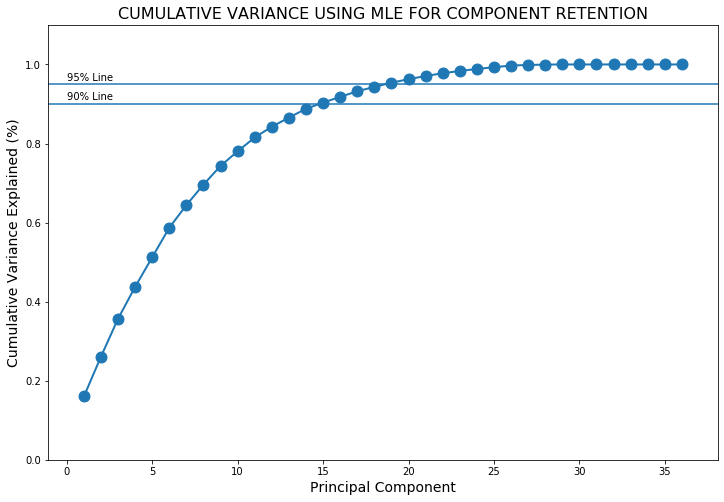

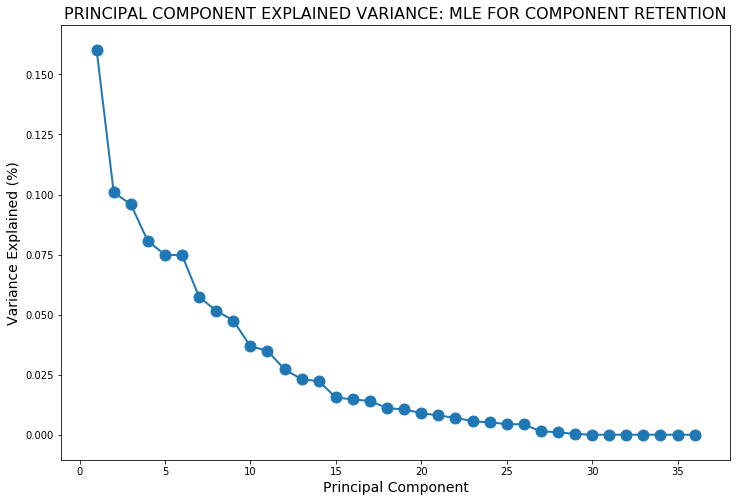

In [635]:
# While we can see the cumluative variance explained in the table above when we add each PC, lets also visualise
# the cumulative variance explained in a plot to help better understand what is occuring in our data  
if isinstance(n_components_output, str):
    title_fig = str('Cumulative Variance Using ' + n_components_output + ' for component retention').upper()
elif isinstance(n_components_output, int):
    title_fig = str('Cumulative Variance using ' + n_components_output + ' components').upper()
else:
    title_fig = str('Cumulative Variance %').upper()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(list(range(1, len(gesture_pca.explained_variance_ratio_)+1)), cum_per.T, lw=2)
ax.scatter(list(range(1, len(gesture_pca.explained_variance_ratio_)+1)), cum_per.T, s=120)
ax.set_title(title_fig, fontsize=16)
ax.set_xlabel('Principal Component', fontsize=14)
ax.set_ylabel('Cumulative Variance Explained (%)', fontsize=14)
plt.ylim(0,1.1)
# plt.axvline(x=upper_sale_residual)
plt.axhline(0.90)
plt.axhline(0.95)
plt.text(-0,0.96,'95% Line')
plt.text(-0,0.91,'90% Line')
plt.show()


#This plot is an alternative looking at the variance explained by each individual component. 
if isinstance(n_components_output, str):
    title_fig = str('Principal Component Explained Variance: ' + n_components_output + ' for component retention').upper()
elif isinstance(n_components_output, int):
    title_fig = str('Principal Component Explained Variance: ' + n_components_output + ' components').upper()
else:
    title_fig = str('Explained Variance %').upper()
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(list(range(1, len(gesture_pca.explained_variance_ratio_)+1)), subj_exp_var_pct.T, lw=2)
ax.scatter(list(range(1, len(gesture_pca.explained_variance_ratio_)+1)), subj_exp_var_pct.T, s=120)
ax.set_title(title_fig, fontsize=16)
ax.set_xlabel('Principal Component', fontsize=14)
ax.set_ylabel('Variance Explained (%)', fontsize=14)
plt.show()

As can be seen, 90% of the variance falls at 15 components (vs 36 in the original), while 95% is at 19. Thus, we can interpret this to mean that using 15 components, we will retain 90% of the original variance in the data set. This can help reduce noise in our data set and improve modelling performance. 

## Gesture Modelling - Creating Training and Testing Sets
I will now model gesture data on the target classes.

<left><img src="https://miro.medium.com/max/2816/1*AVVhcmOs7WCBnpNhqi-L6g.png" width="800" height="100"></left>
<centre>Source: https://medium.com/datadriveninvestor/k-fold-and-other-cross-validation-techniques-6c03a2563f1e</centre>

#### Modelling using Leave One Out (LOO)
Holdout sets are one approach to validation whereby data is broken into a training and testing set, with modelling undertaken on the trianing set and then the model is tested on the testing set to see how it performs. The issue with this approach it that the evaluation can depend on how what data ends in two sets, with some extreme situations meaning that evalulation metrics will be unreliable.

K-fold cross validation is an improved method whereby the data set is broken into a specified number of subsets (k), and then testing is conducted on a holdout. When one of the k subsets is used as a holdout (i.e. for testing), the remaining subsets (k-1) are used for training. The average training error across the k training trials then can be calculated, which will provide a more reliable estimate for how well the model will perfom in the real-world on unseen data. The standard deviation can also provide an indicate of how much variance in performance one can expect. 

As we have a small data-set with only 109 data points, it will be quite difficult when it comes to having enough data points for data modelling and validation. Therefore, I need to select an approach that will maximise the amount of data for modelling while provide an opportunity to assess how the model will perform on a validation data set. 

Leave-one-out (LOO) cross validation is K-fold cross validation taken to its logical extreme, with K equal to N, the number of data points in the set. That means that N separate times, the function approximator is trained on all the data except for one point and a prediction is made for that point. 

For current purposes, therefore, it would make sense to use LOO and then assess how well the modelling predicts the single holdout case. This way, we will be able to test how well the modelling performs. 

In [ ]:
#Initalise an instance of leaveone out to pass to the models.
loo=LeaveOneOut()

#### Baseline Model
First, lets have a look at the baseline we need to achieve, which we get from the largest class of our target.

In [847]:
print("\nPercent of largest class (baseline):", df_original.target_dummy.value_counts(normalize=True).max())


Percent of largest class (baseline): 0.5217391304347826


We therefore have a baseline of 52.29% to achieve in any modelling (which will be the same for all models).

In [637]:
df_unchanged = df_original.copy()

In [638]:
df_original, df_original_test = train_test_split(df_unchanged, test_size=0.15)

#### Gestures - Variable Setup
First, lets create our X and y variables to model the role that gestures play in deception.

In [639]:
#Create gesture X and y variables
X_gesture = df_original[gesture_variables]
y_gesture = df_original.target_dummy

#### Gestures - Modelling
Now I will model gestures using a number of classification models including:

* **Random Forests**
* **Logistical Regression**
* **K-Nearest Neighbour (kNN)**
* **Support Vector Machine (SVM) Classifier (SVC)**

##### Random Forests

In [640]:
#For the first model, I will use random forests, with PCA
#Implements the probabilistic PCA model  
pca = PCA(random_state=random_state)
#Implements an empty Random Forest Classification model  
rf = RandomForestClassifier(random_state=random_state)

#Create a pipeline
pipe_gest = make_pipeline(pca,rf)

#####
params_rf = {'pca__n_components': [15,17,19,21],\
             'randomforestclassifier__max_depth':[3,4,5,6,7],\
             'randomforestclassifier__criterion': ['entropy','gini'],\
             'randomforestclassifier__max_features': [3,4,5,6,10]}

# Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_rf = GridSearchCV(pipe_gest,params_rf,verbose=1,n_jobs=-1)

#8.2. Fit the grid_pipe to the training data
grid_pipe_rf.fit(X_gesture,y_gesture)

#Calculate PCA scores for individual cases
pca_transform_scores = grid_pipe_rf.best_estimator_[0].fit_transform(X_gesture)

#8.3 And print out the best paramters to the screen
prediction_class_rf = grid_pipe_rf.predict(X_gesture)
predication_class_rf_prob = grid_pipe_rf.predict_proba(X_gesture)

#Calculate cv scores using leave one out (loo) for on whole data set
cv_scores = cross_val_score(grid_pipe_rf.best_estimator_, X_gesture, y_gesture, cv=loo)

#To see how accurate our predictions are, as we are using LOO and is a binary target,
#we need to specify those cases when the model correctly classified the target and those
#when it did not in order to calculate the accuracy and generate the confusion matrix
cv_df=pd.Series(cv_scores.copy())
cv_df[(cv_scores==0)&(y_gesture.values==0)] = 1
cv_df[(cv_scores==0)&(y_gesture.values==1)] = 0
cv_df[(cv_scores==1)&(y_gesture.values==0)] = 0
cv_df[(cv_scores==1)&(y_gesture.values==1)] = 1

# confusion_matrix(cv_df.values,y_gesture)

print("Best paramters are: ", grid_pipe_rf.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   48.8s finished


Best paramters are:  {'pca__n_components': 17, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 3}


In [875]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_pipe_rf,'./pickled_models/Gesture_RF_pickle.joblib')

['./pickled_models/Gesture_RF_pickle.joblib']

In [641]:
print("GESTURE - RANDOM FORESTS - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_rf.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_gesture.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores.mean())
print("Std CV score (using best parameters):", cv_scores.std())
print("\nPerformance across models on LOO case")

print("*****************")
print('\nHoldout set size', len(prediction_class_rf))
print("\nClassification report\n",classification_report(cv_df.values,y_gesture))
print("\nConfusion Matrix\n",confusion_matrix(cv_df.values,y_gesture))

GESTURE - RANDOM FORESTS - LOO
---------------------------
Best parameters are:  {'pca__n_components': 17, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 3}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.717391304347826
Std CV score (using best parameters): 0.4502677212436518

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       0.64      0.74      0.68        38
         1.0       0.79      0.70      0.75        54

    accuracy                           0.72        92
   macro avg       0.71      0.72      0.71        92
weighted avg       0.73      0.72      0.72        92


Confusion Matrix
 [[28 10]
 [16 38]]


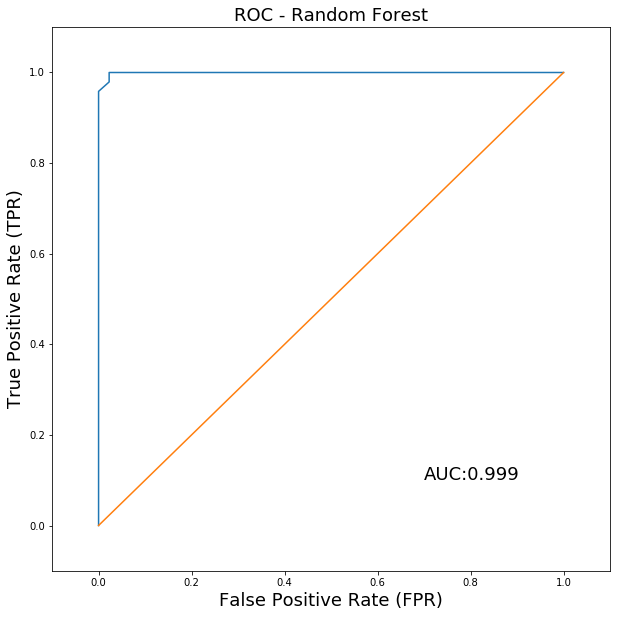

AUC:0.999


In [642]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, predication_class_rf_prob[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - Random Forest', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})
plt.show()
print(AUC)

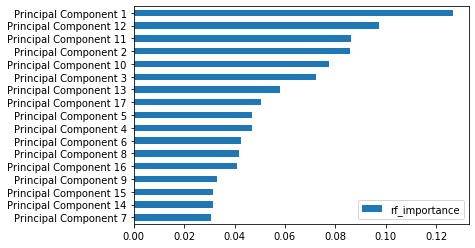

In [848]:
#Lets look at the most important components identified by the random forests
pca_components_list = []

for component in range(0,grid_pipe_rf.best_estimator_[0].n_components):
    to_append = "Principal Component " + str(component +1)
    pca_components_list.append(to_append)

rf_feat_importance = pd.DataFrame(grid_pipe_rf.best_estimator_[-1]\
             .feature_importances_,pca_components_list)\
             .rename(columns={0:'rf_importance'})\


rf_feat_importance.sort_values(by='rf_importance', ascending=True)\
                  .plot(kind='barh')
#As can be seen, the most important compoents are 1, 12, 11, and 2. If we refer back to the Principal Plot
#at the beginning, we can see what types of gestures best represent the compoenent. For example, 
#PC1 has complex hand movement, use of both hands and lips up as key behaviours associated with this class. 

In [644]:
#And we can also plot the decision tree.
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(grid_pipe_rf.best_estimator_[-1].estimators_[grid_pipe_rf.best_index_], out_file='tree.dot', 
                feature_names = rf_feat_importance.index,
                class_names = ['Truthful','Deceptive'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#### Logistical Regression

In [645]:
#Lets now look at the Logistical Regression Model
pca_r = PCA(random_state=random_state)
log_r = LogisticRegression(random_state=random_state)

pipe_gest_log_r = make_pipeline(pca_r,log_r)

#####
params_log_r = {'pca__n_components': [15,17,19,21],\
                'logisticregression__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100], 
                'logisticregression__penalty': ['l1','l2','elasticnet']}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_log_r = GridSearchCV(pipe_gest_log_r,params_log_r,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_log_r.fit(X_gesture,y_gesture)

# #Calculate PCA scores for individual cases
pca_transform_scores_log_r = grid_pipe_log_r.best_estimator_[0].fit_transform(X_gesture)

# #8.3 And print out the best paramters to the screen
prediction_class_log_r = grid_pipe_log_r.predict(X_gesture)
prediction_class_prob_log_r = grid_pipe_log_r.predict_proba(X_gesture)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_log_r = cross_val_score(grid_pipe_log_r.best_estimator_, X_gesture, y_gesture, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_log_r_loo = cv_scores_log_r.copy()

classification_cv_log_r_loo=pd.Series(classification_cv_log_r_loo)
classification_cv_log_r_loo[(classification_cv_log_r_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r_loo[(classification_cv_log_r_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r_loo[(classification_cv_log_r_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r_loo[(classification_cv_log_r_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_log_r.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:    1.7s finished


Best paramters are:  {'logisticregression__C': 3, 'logisticregression__penalty': 'l2', 'pca__n_components': 21}


In [874]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_pipe_log_r,'./pickled_models/Gesture_LR_pickle.joblib')

['./pickled_models/Gesture_LR_pickle.joblib']

In [646]:
print("LOGISTIC REGRESSION CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_log_r.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_gesture.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_log_r.mean())
print("Std CV score (using best parameters):", cv_scores_log_r.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_log_r))
print("\nClassification report\n",classification_report(classification_cv_log_r_loo.values,y_gesture))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r_loo.values,y_gesture))

LOGISTIC REGRESSION CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 3, 'logisticregression__penalty': 'l2', 'pca__n_components': 21}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.7717391304347826
Std CV score (using best parameters): 0.4197116212240831

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        55
         1.0       0.77      1.00      0.87        37

    accuracy                           0.88        92
   macro avg       0.89      0.90      0.88        92
weighted avg       0.91      0.88      0.88        92


Confusion Matrix
 [[44 11]
 [ 0 37]]


Text(0.7, 0.1, 'AUC:0.946')

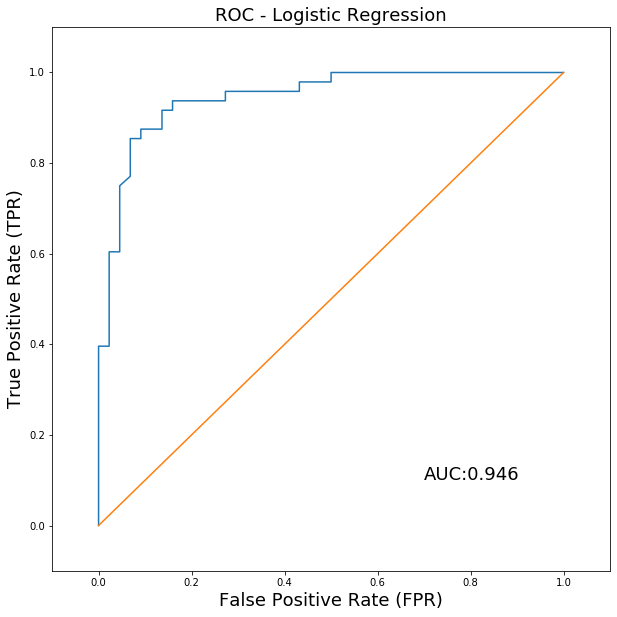

In [647]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_log_r[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - Logistic Regression', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

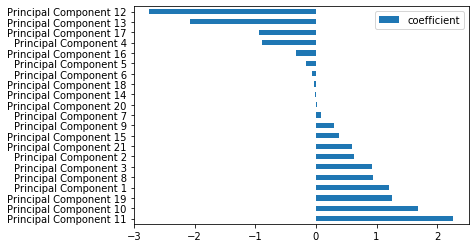

In [648]:
#We can also look at the respective weights of each of the principal components fed into the mode. 
pca_r_components_list = []

for component in range(0,grid_pipe_log_r.best_estimator_[0].n_components):
    to_append = "Principal Component " + str(component +1)
    pca_r_components_list.append(to_append)

log_r_coef = pd.DataFrame(grid_pipe_log_r.best_estimator_[-1]\
             .coef_[0],pca_r_components_list)\
             .rename(columns={0:'coefficient'})\


log_r_coef.sort_values(by='coefficient', ascending=False)\
                  .plot(kind='barh')

#### KNN

In [649]:
#Lets also have a look at KNN model
pca_r = PCA(random_state=random_state)
knn = KNeighborsClassifier()

pipe_gest_knn = make_pipeline(pca_r,knn)

#####
params_knn = {'pca__n_components': [15,17,19,21],\
              'kneighborsclassifier__n_neighbors': range(1,30),\
              'kneighborsclassifier__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],\
              'kneighborsclassifier__p': [1,2]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_knn = GridSearchCV(pipe_gest_knn,params_knn,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_knn.fit(X_gesture,y_gesture)

# #Calculate PCA scores for individual cases
pca_transform_scores_knn = grid_pipe_knn.best_estimator_[0].fit_transform(X_gesture)

# #8.3 And print out the best paramters to the screen
prediction_class_knn = grid_pipe_knn.predict(X_gesture)
prediction_class_probability_knn = grid_pipe_knn.predict_proba(X_gesture)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_knn = cross_val_score(grid_pipe_knn.best_estimator_, X_gesture, y_gesture, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_knn_loo = cv_scores_knn.copy()

classification_cv_knn_loo=pd.Series(classification_cv_knn_loo)
classification_cv_knn_loo[(classification_cv_knn_loo==0)&(y_gesture.values==0)] = 1
classification_cv_knn_loo[(classification_cv_knn_loo==0)&(y_gesture.values==1)] = 0
classification_cv_knn_loo[(classification_cv_knn_loo==1)&(y_gesture.values==0)] = 0
classification_cv_knn_loo[(classification_cv_knn_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_knn.best_params_)

Fitting 5 folds for each of 928 candidates, totalling 4640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 4640 out of 4640 | elapsed:    8.8s finished


Best paramters are:  {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 2, 'pca__n_components': 17}


In [873]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_pipe_knn,'./pickled_models/Gesture_KNN_pickle.joblib')

['./pickled_models/Gesture_KNN_pickle.joblib']

In [650]:
print("KNN CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_knn.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_gesture.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_knn.mean())
print("Std CV score (using best parameters):", cv_scores_knn.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_knn))
print("\nClassification report\n",classification_report(classification_cv_knn_loo.values,y_gesture))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_knn_loo.values,y_gesture))

KNN CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 2, 'pca__n_components': 17}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.7282608695652174
Std CV score (using best parameters): 0.4448561289061114

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.75      0.85        59
         1.0       0.69      1.00      0.81        33

    accuracy                           0.84        92
   macro avg       0.84      0.87      0.83        92
weighted avg       0.89      0.84      0.84        92


Confusion Matrix
 [[44 15]
 [ 0 33]]


Text(0.7, 0.1, 'AUC:0.891')

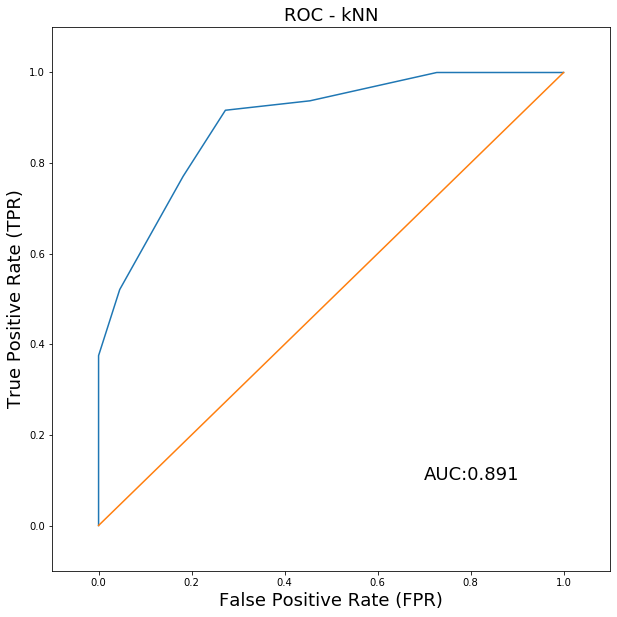

In [849]:
#To help visualise the performance of the KNN model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_probability_knn[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - kNN', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

#### SVM

In [652]:
#Finally, lets run an Support Vector Classifier. 
pca_svc = PCA(random_state=random_state)
svc = SVC(probability=True)

pipe_gest_svc = make_pipeline(pca_svc,svc)

# #####
params_svc = {'pca__n_components': [10,17,19,25,30],\
              'svc__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf']}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_svc = GridSearchCV(pipe_gest_svc,params_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_svc.fit(X_gesture,y_gesture)

# #Calculate PCA scores for individual cases
pca_transform_scores_svc = grid_pipe_svc.best_estimator_[0].fit_transform(X_gesture)

# #8.3 And print out the best paramters to the screen
prediction_class_svc = grid_pipe_svc.predict(X_gesture)
prediction_class_prob_svc = grid_pipe_svc.predict_proba(X_gesture)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_svc = cross_val_score(grid_pipe_svc.best_estimator_, X_gesture, y_gesture, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_svc_loo = cv_scores_svc.copy()

classification_cv_svc_loo=pd.Series(classification_cv_svc_loo)
classification_cv_svc_loo[(classification_cv_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_svc_loo[(classification_cv_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_svc_loo[(classification_cv_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_svc_loo[(classification_cv_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_svc.best_params_)

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 6160 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:   20.1s finished


Best paramters are:  {'pca__n_components': 25, 'svc__C': 100, 'svc__gamma': 0.0021544346900318843, 'svc__kernel': 'rbf'}


In [872]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_pipe_svc,'./pickled_models/Gesture_SVC_pickle.joblib')

['./pickled_models/Gesture_SVC_pickle.joblib']

In [653]:
print("SVC CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_gesture.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_svc.mean())
print("Std CV score (using best parameters):", cv_scores_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_knn))
print("\nClassification report\n",classification_report(classification_cv_svc_loo.values,y_gesture))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_svc_loo.values,y_gesture))

SVC CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'pca__n_components': 25, 'svc__C': 100, 'svc__gamma': 0.0021544346900318843, 'svc__kernel': 'rbf'}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.7391304347826086
Std CV score (using best parameters): 0.43910891036356864

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.77      0.87        57
         1.0       0.73      1.00      0.84        35

    accuracy                           0.86        92
   macro avg       0.86      0.89      0.86        92
weighted avg       0.90      0.86      0.86        92


Confusion Matrix
 [[44 13]
 [ 0 35]]


Text(0.7, 0.1, 'AUC:0.948')

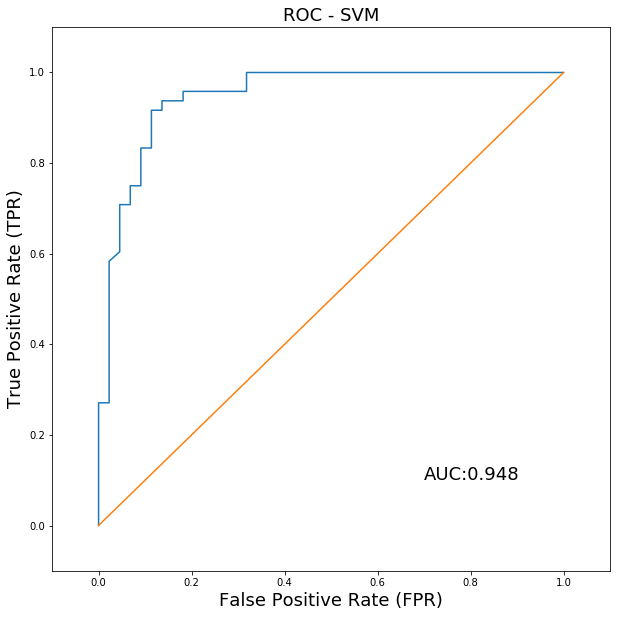

In [654]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC - SVM', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

#### Gesture Model Performance Summary
Overall, the performance of the models are shown below in terms of Cross Validation scores, F1, and AUC

| Model | CV | CV Sd | F1 | AUC |
| --- | --- | --- | --- | --- |
| Random Forest | 0.72 | 0.45 | 0.72 | 1.0 |
| Logistic Regression | 0.77 | 0.42 | 0.88 | 0.95 |
| KNN | 0.73 | 0.44 | 0.84 | 0.89 |
| SVC | 0.74 | 0.44 | 0.86 | 0.95 |

As can be seen, Logistic Regression performed the best in terms of CV and so moves forward to the fusion model.

## Vocal Feature Modelling
Lets now look at modelling the vocal features.

A key aspect to consider for feature selection is that each instance has different lengths of time speaking. Therefore, pure counts of some vocal features would not be appropriate (e.g. count of syablles) as otherwise it may be simply that higher counts get identified rather than a rate. Therefore, I will engineeer features to a directly comparable time metric based on rate of use to facilitate more appropriate comparisons (such rate of speech and ratio of speaking to duration).

In [655]:
#Again, lets create some lists of features broken into key areas that we can use in modelling if needed.
vocal_features_counts = ['Count of Syllables',
                         'Count of filler and pauses']
vocal_features_time =   ['Speaking time secs w/o pauses',
                         'Duration time secs w pauses']  

#For modelliling purposes, the following vocal features can be used.
vocal_features_rate =   ['Rate of speech - syb per sec']

vocal_features_ratio =  ['Ratio speaking to duration']

vocal_features_jitter = ['Jitter - local',
                         'Jitter - local, absolute',
                         'Jitter - rap',
                         'Jitter - ppq5',
                         'Jitter - ddp']

vocal_features_FF     = ['Fundamental frequency_f0 Hz', 
                         'SD Fundamental frequency_f0 Hz',
                         'Median Fundamental frequency_f0 Hz',
                         'Minimum Fundamental frequency_f0 Hz',
                         'Maximum Fundamental frequency_f0 Hz',
                         '25th Quantile Fundamental frequency_f0 Hz',
                         '75th Quantile Fundamental frequency_f0 Hz',
                         'diff_max_mix',
                         'diff_25_75']

#All cocal features for X. 
all_vocal_features =    ['Rate of speech - syb per sec',
                         'Ratio speaking to duration',
                         'Jitter - local',
                         'Jitter - local, absolute',
                         'Jitter - rap',
                         'Jitter - ppq5',
                         'Jitter - ddp',
                         'Fundamental frequency_f0 Hz', 
                         'SD Fundamental frequency_f0 Hz',
                         'Median Fundamental frequency_f0 Hz',
                         'Minimum Fundamental frequency_f0 Hz',
                         'Maximum Fundamental frequency_f0 Hz',
                         '25th Quantile Fundamental frequency_f0 Hz',
                         '75th Quantile Fundamental frequency_f0 Hz',
                         'diff_max_mix',
                         'diff_25_75']

all_vocal_features_alt =    ['Rate of speech - syb per sec',
                         'Ratio speaking to duration',
                         'Jitter - local',
                         'Jitter - local, absolute',
                         'Jitter - rap',
                         'Jitter - ppq5',
                         'Jitter - ddp',
                         'Fundamental frequency_f0 Hz', 
                         'SD Fundamental frequency_f0 Hz',
                         'Median Fundamental frequency_f0 Hz',
                         'Minimum Fundamental frequency_f0 Hz',
                         'Maximum Fundamental frequency_f0 Hz',
                         '25th Quantile Fundamental frequency_f0 Hz',
                         '75th Quantile Fundamental frequency_f0 Hz',
                         'diff_max_mix',
                         'diff_25_75',
                         'Pronunciation_posteriori']

#During my EDA (see book 2), I also want to investigate a potential interaction between 
df_original['gender_interaction_diff_25_75'] = df_original.Gender_dummy * df_original.diff_25_75


C:\Users\matth\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [656]:
#To ensure that the test features are are changed in the same way, I will apply the same formula 
df_original_test['gender_interaction_diff_25_75'] = df_original_test.Gender_dummy * df_original_test.diff_25_75

C:\Users\matth\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [657]:
#Create gesture X and y variables
all_vocal_features.append('Gender_dummy')
all_vocal_features.append('gender_interaction_diff_25_75')

X_vocal = df_original[all_vocal_features]
y_vocal = df_original.target_dummy
#And create training and testing class. As we don't have a lot of data for training, 
#lets keep 10% aside as a validation set. However, we will also investigate the best approach

#### Vocal Modelling - Logistic Regression

In [854]:
#Lets now run a logistic regression model on the vocal features and try out 
log_r_vocal = LogisticRegression(random_state=random_state, max_iter=2000)
pipe_vocal = make_pipeline(StandardScaler(),log_r_vocal)

#####
params_log_r_vocal = {'logisticregression__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100],\
                      'logisticregression__penalty': ['l1','l2','elasticnet'],\
                      'logisticregression__solver': ['newton-cg','liblinear','saga']}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_log_r_vocal = GridSearchCV(pipe_vocal,params_log_r_vocal,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_log_r_vocal.fit(X_vocal,y_vocal)

# #8.3 And print out the best paramters to the screen
prediction_class_log_r_vocal = grid_log_r_vocal.predict(X_vocal)
prediction_class_prob_log_r_vocal = grid_log_r_vocal.predict_proba(X_vocal)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_log_r_vocal = cross_val_score(grid_log_r_vocal.best_estimator_, X_vocal, y_vocal, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_log_r__vocal_loo = cv_scores_log_r_vocal.copy()

classification_cv_log_r__vocal_loo=pd.Series(classification_cv_log_r__vocal_loo)
classification_cv_log_r__vocal_loo[(classification_cv_log_r__vocal_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r__vocal_loo[(classification_cv_log_r__vocal_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r__vocal_loo[(classification_cv_log_r__vocal_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r__vocal_loo[(classification_cv_log_r__vocal_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_log_r_vocal.best_params_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:    5.1s finished


Best paramters are:  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}


In [871]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_log_r_vocal,'./pickled_models/Vocal_LR_pickle.joblib')

['./pickled_models/Vocal_LR_pickle.joblib']

In [659]:
print("VOCAL - LOGISTIC REGRESSION CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_log_r_vocal.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_vocal.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_log_r_vocal.mean())
print("Std CV score (using best parameters):", cv_scores_log_r_vocal.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_log_r_vocal))
print("\nClassification report\n",classification_report(classification_cv_log_r__vocal_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r__vocal_loo.values,y_vocal))

VOCAL - LOGISTIC REGRESSION CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 100, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.6956521739130435
Std CV score (using best parameters): 0.4601306627938418

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.77      0.87        57
         1.0       0.73      1.00      0.84        35

    accuracy                           0.86        92
   macro avg       0.86      0.89      0.86        92
weighted avg       0.90      0.86      0.86        92


Confusion Matrix
 [[44 13]
 [ 0 35]]


Text(0.7, 0.1, 'AUC:0.887')

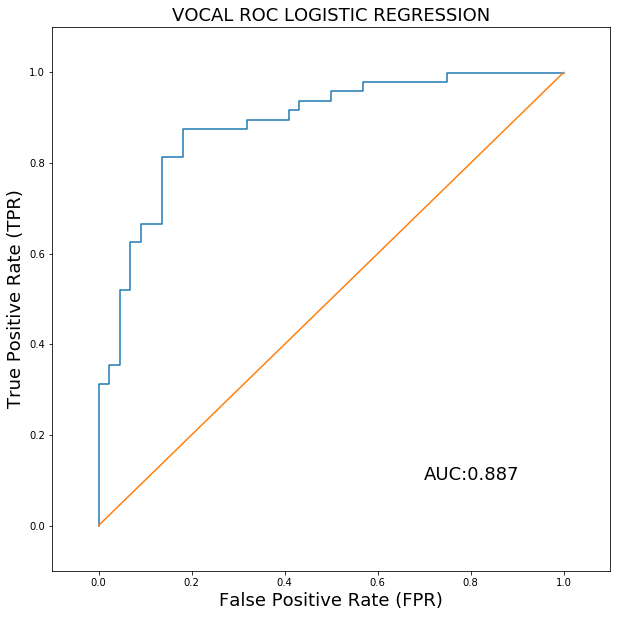

In [660]:
#To help visualise the performance of the logisitic regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_log_r_vocal[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('VOCAL ROC LOGISTIC REGRESSION', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

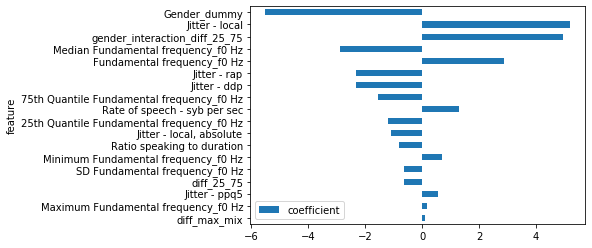

In [661]:
log_r__vocal_coef = pd.DataFrame(grid_log_r_vocal.best_estimator_[-1]\
             .coef_[0],X_vocal.columns)\
             .rename(columns={0:'coefficient'}).reset_index().rename(columns={'index':'feature'})\

log_r__vocal_coef['abs_coefficient'] = abs(log_r__vocal_coef.coefficient)
log_r__vocal_coef.sort_values(by='abs_coefficient', ascending=True).plot.barh(x='feature',y='coefficient')

#### Vocal Modelling - Random Forests

In [662]:
#Now lets run a random forsts on the data
rf_vocal = RandomForestClassifier(random_state=random_state)
pipe_rf_vocal = make_pipeline(StandardScaler(),rf_vocal)

#####
params_rf_vocal = {'randomforestclassifier__max_depth':[2,3,4,5],\
                   'randomforestclassifier__criterion': ['entropy','gini'],\
                   'randomforestclassifier__max_features': [3,4,5,6]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_rf_vocal = GridSearchCV(pipe_rf_vocal,params_rf_vocal,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_rf_vocal.fit(X_vocal,y_vocal)

# #8.3 And print out the best paramters to the screen
prediction_class_rf_vocal = grid_rf_vocal.predict(X_vocal)
prediction_class_prob_rf_vocal = grid_rf_vocal.predict_proba(X_vocal)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_rf_vocal = cross_val_score(grid_rf_vocal.best_estimator_, X_vocal, y_vocal, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_rf__vocal_loo = cv_scores_rf_vocal.copy()

classification_cv_rf__vocal_loo=pd.Series(classification_cv_rf__vocal_loo)
classification_cv_rf__vocal_loo[(classification_cv_rf__vocal_loo==0)&(y_gesture.values==0)] = 1
classification_cv_rf__vocal_loo[(classification_cv_rf__vocal_loo==0)&(y_gesture.values==1)] = 0
classification_cv_rf__vocal_loo[(classification_cv_rf__vocal_loo==1)&(y_gesture.values==0)] = 0
classification_cv_rf__vocal_loo[(classification_cv_rf__vocal_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_rf_vocal.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    8.3s finished


Best paramters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 6}


In [870]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_rf_vocal,'./pickled_models/Vocal_RF_pickle.joblib')

['./pickled_models/Vocal_RF_pickle.joblib']

In [663]:
print("VOCAL - RANDOM FOREST CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_rf_vocal.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_vocal.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_rf_vocal.mean())
print("Std CV score (using best parameters):", cv_scores_rf_vocal.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_rf_vocal))
print("\nClassification report\n",classification_report(classification_cv_rf__vocal_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_rf__vocal_loo.values,y_vocal))

VOCAL - RANDOM FOREST CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__max_features': 6}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.6086956521739131
Std CV score (using best parameters): 0.48804226784007926

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.75      0.85        59
         1.0       0.69      1.00      0.81        33

    accuracy                           0.84        92
   macro avg       0.84      0.87      0.83        92
weighted avg       0.89      0.84      0.84        92


Confusion Matrix
 [[44 15]
 [ 0 33]]


Text(0.7, 0.1, 'AUC:0.91')

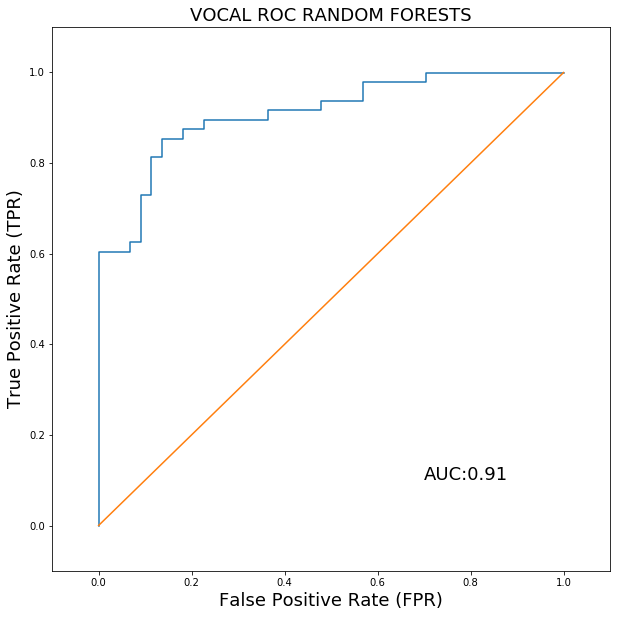

In [664]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_rf_vocal[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('VOCAL ROC RANDOM FORESTS', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

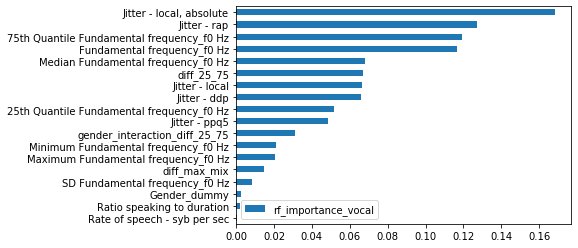

In [665]:
#Lets also 
rf_vocal_feat_importance = pd.DataFrame(grid_rf_vocal.best_estimator_[-1].feature_importances_,\
                                        X_vocal.columns)\
                                         .rename(columns={0:'rf_importance_vocal'})\

rf_vocal_feat_importance.sort_values(by='rf_importance_vocal',\
                                     ascending=True)\
                                     .plot(kind='barh')

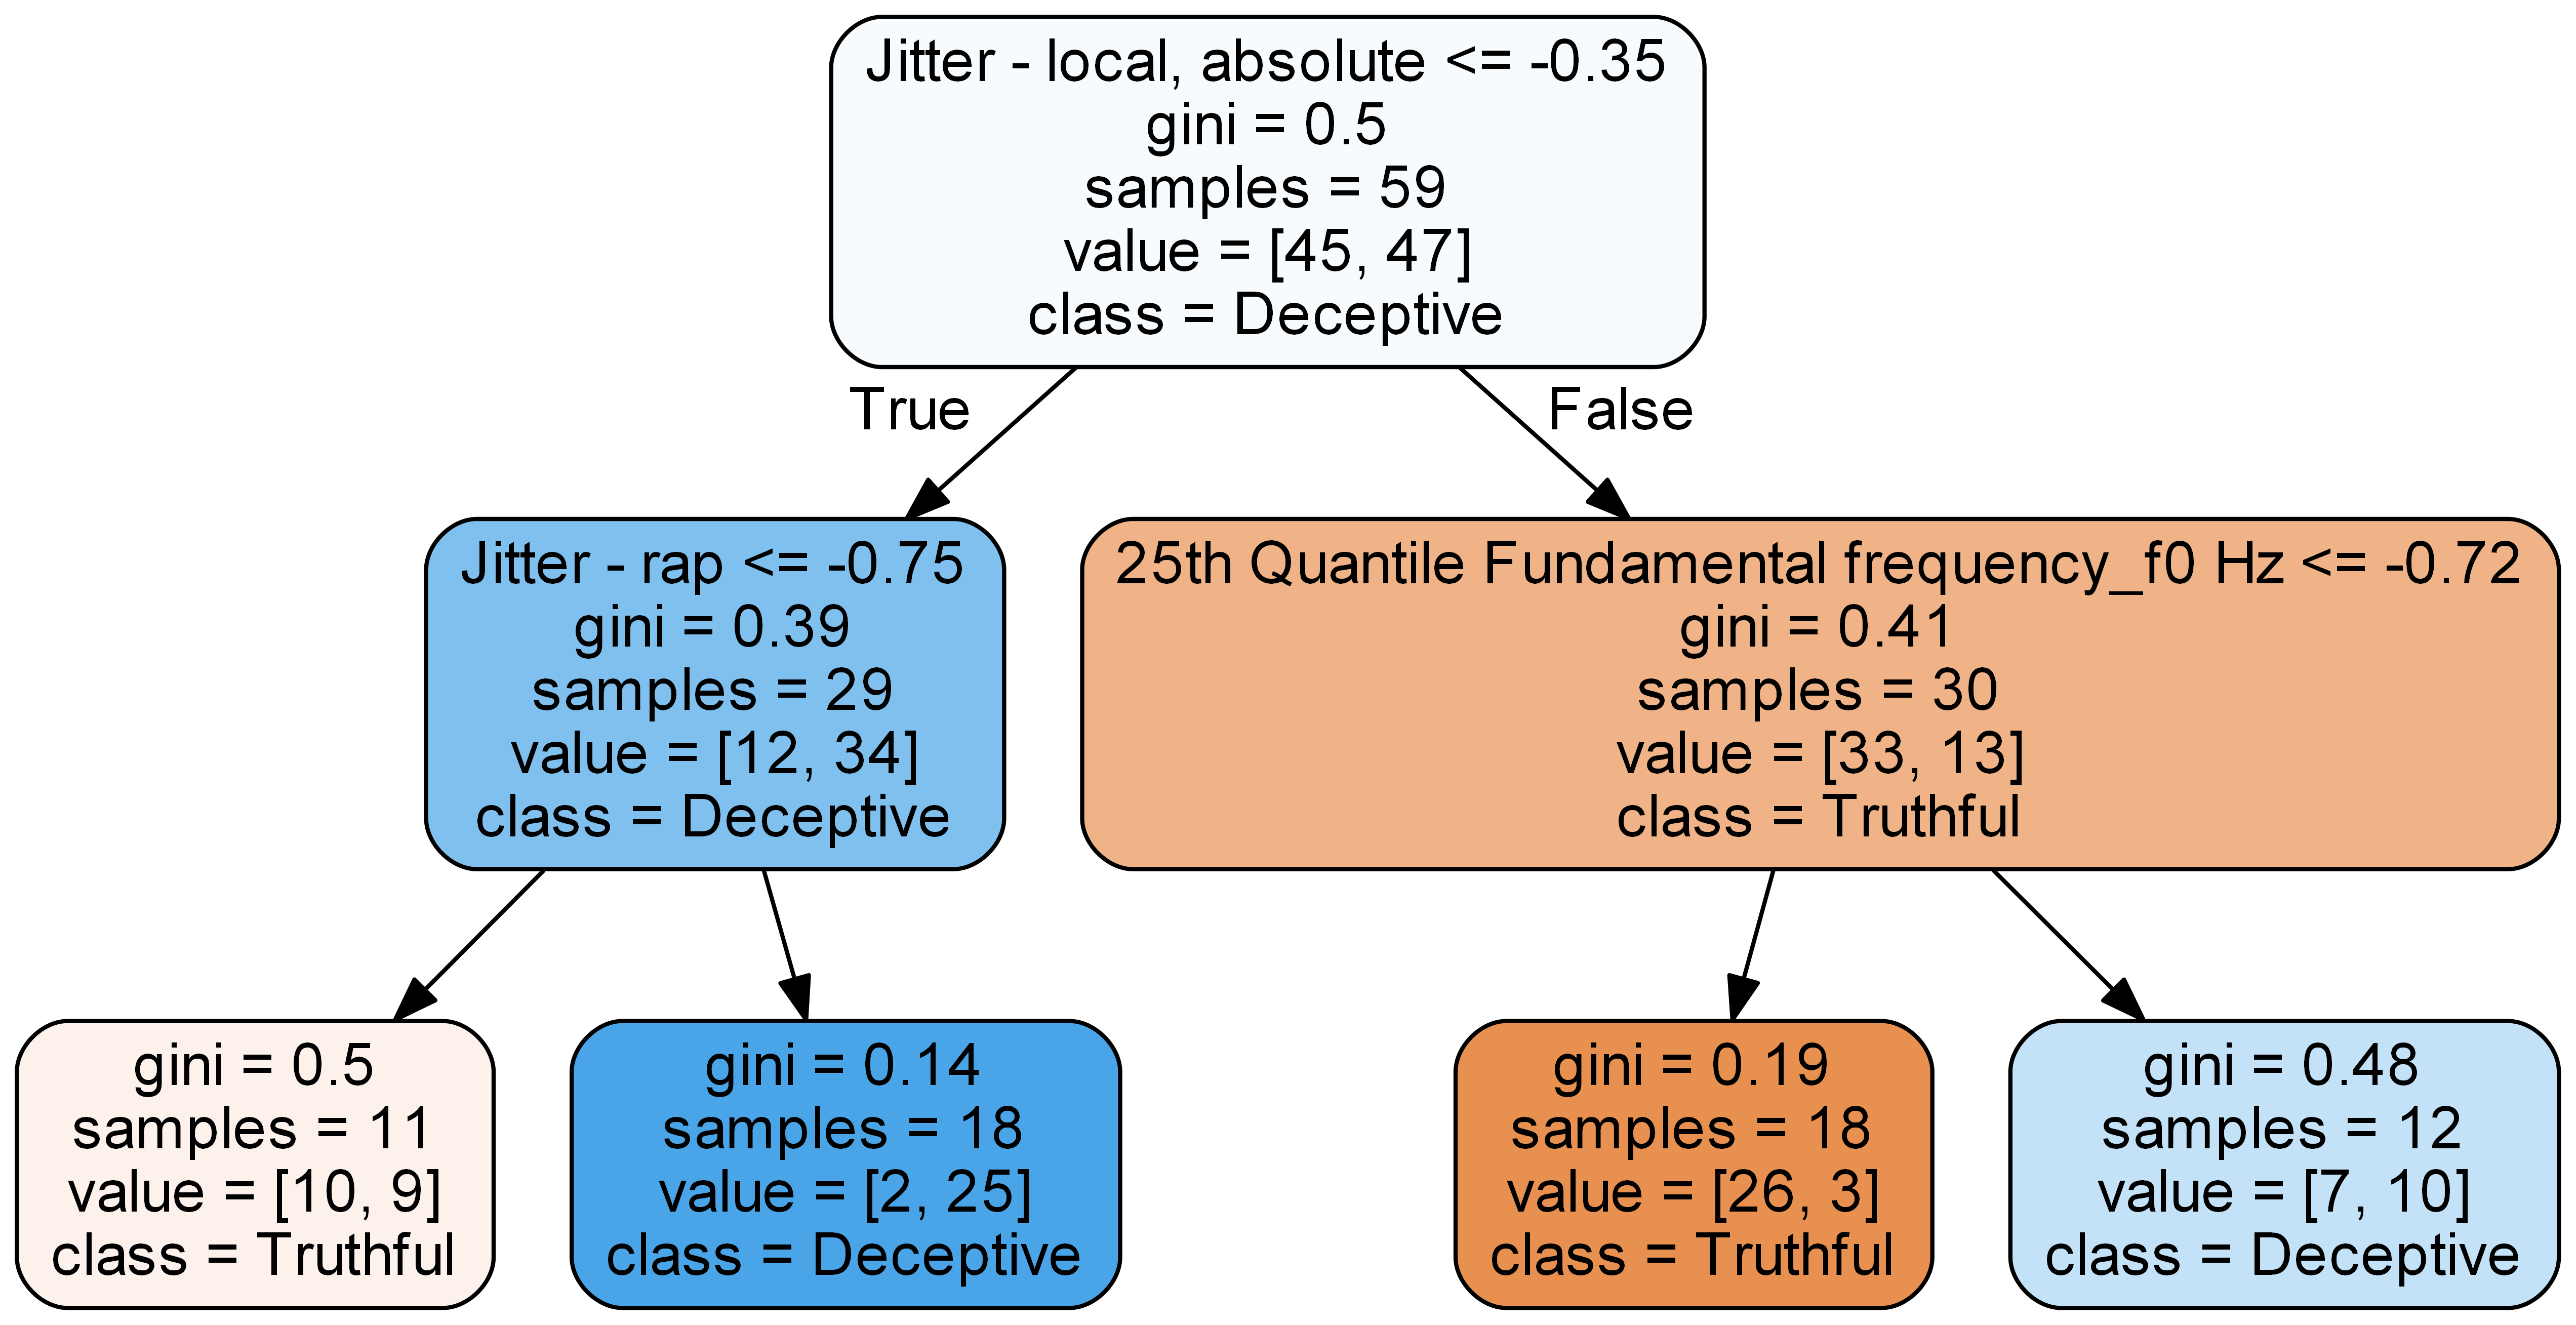

In [666]:
# Lets also have a look 
export_graphviz(grid_rf_vocal.best_estimator_[-1].estimators_[grid_rf_vocal.best_index_], out_file='tree.dot', 
                feature_names = rf_vocal_feat_importance.index,
                class_names = ['Truthful','Deceptive'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

#### Vocal Modelling - SVM

In [667]:

random_state = 42

svc_vocal = SVC(probability=True)

pipe_vocal_svc = make_pipeline(StandardScaler(),svc_vocal)

# #####
params_vocal_svc = {'svc__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,40,50,60,70,100],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf']}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_vocal_svc = GridSearchCV(pipe_vocal_svc,params_vocal_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_vocal_svc.fit(X_vocal,y_vocal)

# #8.3 And print out the best paramters to the screen
prediction_class_vocal_svc = grid_pipe_vocal_svc.predict(X_vocal)
prediction_class_vocal_prob_svc = grid_pipe_vocal_svc.predict_proba(X_vocal)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_vocal_svc = cross_val_score(grid_pipe_vocal_svc.best_estimator_, X_vocal,y_vocal, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_vocal_svc_loo = cv_scores_vocal_svc.copy()

classification_cv_vocal_svc_loo=pd.Series(classification_cv_vocal_svc_loo)
classification_cv_vocal_svc_loo[(classification_cv_vocal_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_vocal_svc_loo[(classification_cv_vocal_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_vocal_svc_loo[(classification_cv_vocal_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_vocal_svc_loo[(classification_cv_vocal_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_vocal_svc.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2020 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:   13.0s finished


Best paramters are:  {'svc__C': 70, 'svc__gamma': 1e-05, 'svc__kernel': 'linear'}


In [869]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_pipe_vocal_svc,'./pickled_models/Vocal_SVC_pickle.joblib')

['./pickled_models/Vocal_SVC_pickle.joblib']

In [668]:
print("VOCAL - SVM CLASSIFICATION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_vocal_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_vocal.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_vocal_svc.mean())
print("Std CV score (using best parameters):", cv_scores_vocal_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_vocal_svc))
print("\nClassification report\n",classification_report(classification_cv_vocal_svc_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_vocal_svc_loo.values,y_vocal))

VOCAL - SVM CLASSIFICATION MODEL - LOO
---------------------------
Best parameters are:  {'svc__C': 70, 'svc__gamma': 1e-05, 'svc__kernel': 'linear'}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.7282608695652174
Std CV score (using best parameters): 0.4448561289061114

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.77      0.87        57
         1.0       0.73      1.00      0.84        35

    accuracy                           0.86        92
   macro avg       0.86      0.89      0.86        92
weighted avg       0.90      0.86      0.86        92


Confusion Matrix
 [[44 13]
 [ 0 35]]


Text(0.7, 0.1, 'AUC:0.886')

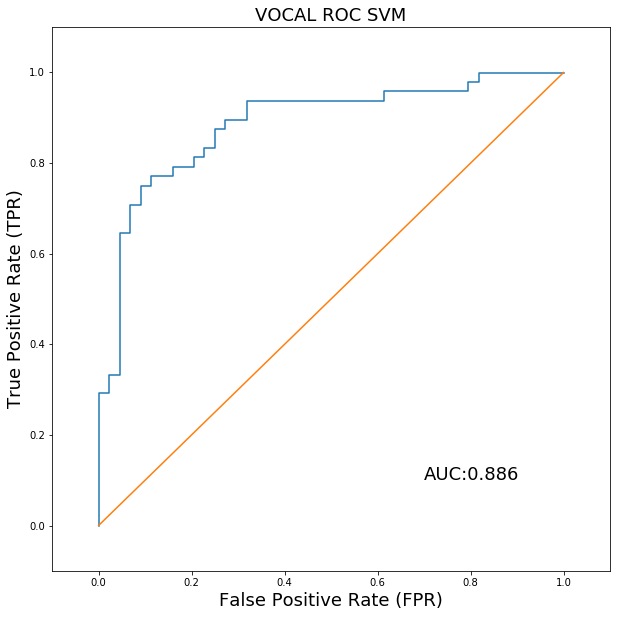

In [669]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_vocal_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('VOCAL ROC SVM', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

#### Vocal Model Performance Summary
Overall, the performance of the models are shown below in terms of Cross Validation scores, F1, and AUC

| Model | CV | CV Sd | F1 | AUC |
| --- | --- | --- | --- | --- |
| Random Forest | 0.61 | 0.49 | 0.84 | 0.91 |
| Logistic Regression | 0.70 | 0.46 | 0.86 | 0.89 |
| SVC | 0.73 | 0.44 | 0.86 | 0.89 |

As can be seen, SVC performed the best in terms of CV and so moves forward to the fusion model.

# Lexical Feature Modelling
Lets now look at the lexical features. For this part of the modelling, I will be looking at creating three seperate models focused on:

1. **Parts of Speech (POS)**: a part of speech is a category of words (or, more generally, of lexical items) that have similar grammatical properties.
2. **Sentiment**: assessing the polarity and subjectivity of statements.
3. **Bag of Words**: assessing whether there are key words that may distingush between truthful and deceptive statements.

## Parts of Speech (POS)

Before modelling POS, I need to do some feature engineering, which will do using textblob. I will also undertake some data exploration to see if there are differences in use between deceptive and truthful statements. 

In [670]:
#Let's first create new working lexical dataframe to work with for the current modelling. 
df_lexical = df_original.copy()
#Drop Gesture variables
df_lexical.drop(gesture_variables,axis=1,inplace=True)
#and then all other vocal feature variables and other features not used. 
df_lexical.drop(['Pronunciation_posteriori', 'Gender', 'Mood_from_mva',
       'Count of Syllables', 'Count of filler and pauses',
       'Rate of speech - syb per sec', 'Duration time secs w pauses',
       'Ratio speaking to duration',
       'Fundamental frequency_f0 Hz', 'SD Fundamental frequency_f0 Hz',
       'Median Fundamental frequency_f0 Hz',
       'Minimum Fundamental frequency_f0 Hz',
       'Maximum Fundamental frequency_f0 Hz',
       '25th Quantile Fundamental frequency_f0 Hz',
       '75th Quantile Fundamental frequency_f0 Hz', 'Jitter - local',
       'Jitter - local, absolute', 'Jitter - rap', 'Jitter - ppq5',
       'Jitter - ddp','pauses_per_minute',
       'log_pauses_per_minute', 'diff_max_mix', 'diff_25_75','target'],axis=1, inplace=True)

In [671]:
#As I need to test the data later on the holdout set, so lets create the same process for this.  
df_lexical_test = df_original_test.copy()
#Drop Gesture variables
df_lexical_test.drop(gesture_variables,axis=1,inplace=True)
#and then all other vocal feature variables and other features not used. 
df_lexical_test.drop(['Pronunciation_posteriori', 'Gender', 'Mood_from_mva',
       'Count of Syllables', 'Count of filler and pauses',
       'Rate of speech - syb per sec', 'Duration time secs w pauses',
       'Ratio speaking to duration',
       'Fundamental frequency_f0 Hz', 'SD Fundamental frequency_f0 Hz',
       'Median Fundamental frequency_f0 Hz',
       'Minimum Fundamental frequency_f0 Hz',
       'Maximum Fundamental frequency_f0 Hz',
       '25th Quantile Fundamental frequency_f0 Hz',
       '75th Quantile Fundamental frequency_f0 Hz', 'Jitter - local',
       'Jitter - local, absolute', 'Jitter - rap', 'Jitter - ppq5',
       'Jitter - ddp','pauses_per_minute',
       'log_pauses_per_minute', 'diff_max_mix', 'diff_25_75','target'],axis=1, inplace=True)

In [672]:
#I Will also create some copies of the column we will use for the bag of words model for the training and testing data sets
X_lexical = df_lexical.transcription.copy()
X_lexical_test = df_lexical_test.transcription.copy()

As we are interested in use of parts of speech (e.g. personal pronouns), lets first extract the Parts of Speech (POS) information from the transcriptions. To achieve this, I will use TextBlob, which has a POS module (.tags). The parts of speech that are tagged are based on the following.

In [674]:
#Create a dictionary of Parts of Speech counts to append to original lexical dataframe
pos_dict = {}

for i,x in enumerate(X_lexical):
    textblob_lex = TextBlob(x)
    counts = dict(Counter(tag for word,tag in textblob_lex.tags))
    pos_dict.update({X_lexical.index[i]: counts})

#Create a parts of speech dataframe from the newly created dictionary
pos_df = pd.DataFrame(pos_dict).T

#And then conctenate the lexical and pos_df dataframes
df_lexical = pd.concat([df_lexical,pos_df], axis=1)

In [675]:
#Create a dictionary of Parts of Speech counts to append to original lexical dataframe
pos_dict_test = {}

for i,x in enumerate(X_lexical_test):
    textblob_lex = TextBlob(x)
    counts = dict(Counter(tag for word,tag in textblob_lex.tags))
    pos_dict_test.update({df_lexical_test.index[i]: counts})

# #Create a parts of speech dataframe from the newly created dictionary
pos_df_test = pd.DataFrame(pos_dict_test).T

# #And then conctenate the lexical and pos_df dataframes
df_lexical_test = pd.concat([df_lexical_test,pos_df_test], axis=1)

# #As some POS are not found in the testing set, lets create these so that issues do not occur later on
df_lexical_test['FW'] = 0 
df_lexical_test['NNPS'] = 0 

In [676]:
#Now we have our POS counts, lets create a columns list to speed things up when masking if needed
pos_columns = ['DT', 'NN', 'PRP', 'VBD', 'RB', 'CC',
               'IN', 'VBN', 'VBG', 'TO', 'WDT', 'VBZ', 'VBP', 'NNS', 'JJ', 'WRB',
               'NNP', 'PRP$', 'VB', 'RP', 'WP', 'MD', 'CD', 'EX', 'RBR', 'JJR',
               'UH', 'JJS', 'FW', 'NNPS']

For similar reasons as for vocal features, as the length of times speaking differ for each row I will convert use in terms of rate of use over a particular time. Therefore, lets create a POS use rate per minute by dividing each POS by the total time speaking without pauses. This will create a ratio variable for each part of speech use (POS Per Minute).

In [677]:
df_lexical = df_lexical.join(df_lexical[pos_columns].apply(lambda x:(df_lexical['Speaking time secs w/o pauses'] /60) * x),rsuffix='_use_per_min')

In [678]:
pos_columns = ['DT', 'NN', 'PRP', 'VBD', 'RB', 'CC',
               'IN', 'VBN', 'VBG', 'TO', 'WDT', 'VBZ', 'VBP', 'NNS', 'JJ', 'WRB',
               'NNP', 'PRP$', 'VB', 'RP', 'WP', 'MD', 'CD', 'EX',
               'UH', 'FW', 'NNPS']

In [679]:
df_lexical_test = df_lexical_test.join(df_lexical_test[pos_columns].apply(lambda x:(df_lexical_test['Speaking time secs w/o pauses'] /60) * x),rsuffix='_use_per_min')

In [680]:
pos_columns_use_per_min = ['DT_use_per_min', 'NN_use_per_min',
       'PRP_use_per_min', 'VBD_use_per_min', 'RB_use_per_min',
       'CC_use_per_min', 'IN_use_per_min', 'VBN_use_per_min',
       'VBG_use_per_min', 'TO_use_per_min', 'WDT_use_per_min',
       'VBZ_use_per_min', 'VBP_use_per_min', 'NNS_use_per_min',
       'JJ_use_per_min', 'WRB_use_per_min', 'NNP_use_per_min',
       'PRP$_use_per_min', 'VB_use_per_min', 'RP_use_per_min',
       'WP_use_per_min', 'MD_use_per_min', 'CD_use_per_min',
       'EX_use_per_min',
       'UH_use_per_min', 'FW_use_per_min',
       'NNPS_use_per_min']

In [681]:
#Lets inspect the null values
df_lexical[pos_columns_use_per_min].isnull().sum()

DT_use_per_min       3
NN_use_per_min       2
PRP_use_per_min      0
VBD_use_per_min      8
RB_use_per_min       9
CC_use_per_min      12
IN_use_per_min       5
VBN_use_per_min     38
VBG_use_per_min     35
TO_use_per_min      30
WDT_use_per_min     73
VBZ_use_per_min     49
VBP_use_per_min     18
NNS_use_per_min     21
JJ_use_per_min      12
WRB_use_per_min     54
NNP_use_per_min     24
PRP$_use_per_min    40
VB_use_per_min      22
RP_use_per_min      69
WP_use_per_min      65
MD_use_per_min      62
CD_use_per_min      60
EX_use_per_min      74
UH_use_per_min      72
FW_use_per_min      91
NNPS_use_per_min    89
dtype: int64

In [682]:
#As we are interested in use, we can replace all null values with 0
df_lexical[pos_columns_use_per_min] = df_lexical[pos_columns_use_per_min].fillna(0)

In [683]:
df_lexical_test[pos_columns_use_per_min].isnull().sum()

DT_use_per_min       0
NN_use_per_min       0
PRP_use_per_min      0
VBD_use_per_min      1
RB_use_per_min       2
CC_use_per_min       1
IN_use_per_min       0
VBN_use_per_min      7
VBG_use_per_min      6
TO_use_per_min       3
WDT_use_per_min     12
VBZ_use_per_min      8
VBP_use_per_min      4
NNS_use_per_min      3
JJ_use_per_min       4
WRB_use_per_min     10
NNP_use_per_min      4
PRP$_use_per_min     7
VB_use_per_min       2
RP_use_per_min      10
WP_use_per_min       7
MD_use_per_min      10
CD_use_per_min      11
EX_use_per_min      16
UH_use_per_min      14
FW_use_per_min       0
NNPS_use_per_min     0
dtype: int64

In [684]:
#As we are interested in use, we can replace all null values with 0
df_lexical_test[pos_columns_use_per_min] = df_lexical_test[pos_columns_use_per_min].fillna(0)

In [685]:
#Lets inspect descriptive statistics of use per minute
df_lexical[pos_columns_use_per_min].describe().T

count      mean       std    min       25%       50%  \
DT_use_per_min     92.0  2.067464  3.139971  0.000  0.451667  1.010000   
NN_use_per_min     92.0  3.509004  5.250608  0.000  0.744583  2.085000   
PRP_use_per_min    92.0  3.424801  4.494447  0.035  0.640417  2.022500   
VBD_use_per_min    92.0  2.267663  3.425610  0.000  0.337083  1.200000   
RB_use_per_min     92.0  1.903279  2.277141  0.000  0.311250  1.156667   
CC_use_per_min     92.0  1.270217  1.904541  0.000  0.207500  0.697500   
IN_use_per_min     92.0  2.739674  3.772709  0.000  0.601667  1.875000   
VBN_use_per_min    92.0  0.429638  0.636386  0.000  0.000000  0.192500   
VBG_use_per_min    92.0  0.540471  0.822871  0.000  0.000000  0.231667   
TO_use_per_min     92.0  0.697935  1.085920  0.000  0.000000  0.299167   
WDT_use_per_min    92.0  0.114040  0.260818  0.000  0.000000  0.000000   
VBZ_use_per_min    92.0  0.346069  0.610355  0.000  0.000000  0.000000   
VBP_use_per_min    92.0  0.913007  1.267440  0.000  0.156667  0.457500   
NNS_use_per_min    92.0  0.706576  1.078346  0.000  0.093333  0.406667   
JJ_use_per_min     92.0  1.266232  1.571872  0.000  0.214583  0.745000   
WRB_use_per_min    92.0  0.220543  0.391510  0.000  0.000000  0.000000   
NNP_use_per_min    92.0  0.838750  1.229423  0.000  0.000000  0.303333   
PRP$_use_per_min   92.0  0.529710  0.879972  0.000  0.000000  0.208333   
VB_use_per_min     92.0  0.985326  1.624004  0.000  0.084583  0.424167   
RP_use_per_min     92.0  0.166087  0.399798  0.000  0.000000  0.000000   
WP_use_per_min     92.0  0.194728  0.508795  0.000  0.000000  0.000000   
MD_use_per_min     92.0  0.196576  0.405166  0.000  0.000000  0.000000   
CD_use_per_min     92.0  0.253170  0.587562  0.000  0.000000  0.000000   
EX_use_per_min     92.0  0.087355  0.231336  0.000  0.000000  0.000000   
UH_use_per_min     92.0  0.173804  0.709649  0.000  0.000000  0.000000   
FW_use_per_min     92.0  0.002627  0.025195  0.000  0.000000  0.000000   
NNPS_use_per_min   92.0  0.016431  0.105550  0.000  0.000000  0.000000   

                       75%        max  
DT_use_per_min    2.528750  22.360000  
NN_use_per_min    4.020000  40.993333  
PRP_use_per_min   4.075000  28.733333  
VBD_use_per_min   2.713750  20.831667  
RB_use_per_min    2.581250  12.111667  
CC_use_per_min    1.647917  13.043333  
IN_use_per_min    3.357083  27.950000  
VBN_use_per_min   0.538750   2.841667  
VBG_use_per_min   0.806667   4.310000  
TO_use_per_min    0.824167   6.521667  
WDT_use_per_min   0.000000   1.070000  
VBZ_use_per_min   0.414167   2.933333  
VBP_use_per_min   1.025833   6.251667  
NNS_use_per_min   0.769167   7.850000  
JJ_use_per_min    1.782917   7.980000  
WRB_use_per_min   0.311250   1.766667  
NNP_use_per_min   1.067500   6.781667  
PRP$_use_per_min  0.552500   3.726667  
VB_use_per_min    1.155000  10.798333  
RP_use_per_min    0.029583   2.355000  
WP_use_per_min    0.226250   3.666667  
MD_use_per_min    0.250000   2.273333  
CD_use_per_min    0.252500   3.266667  
EX_use_per_min    0.000000   1.570000  
UH_use_per_min    0.000000   6.280000  
FW_use_per_min    0.000000   0.241667  
NNPS_use_per_min  0.000000   0.931667

In [686]:
(df_lexical[pos_columns_use_per_min].describe().T['50%'] == 0).sort_values().index

Index(['DT_use_per_min', 'VB_use_per_min', 'PRP$_use_per_min',
       'NNP_use_per_min', 'JJ_use_per_min', 'VBP_use_per_min',
       'TO_use_per_min', 'VBG_use_per_min', 'NNS_use_per_min',
       'IN_use_per_min', 'NN_use_per_min', 'VBN_use_per_min',
       'VBD_use_per_min', 'RB_use_per_min', 'PRP_use_per_min',
       'CC_use_per_min', 'WRB_use_per_min', 'VBZ_use_per_min',
       'WDT_use_per_min', 'RP_use_per_min', 'WP_use_per_min', 'MD_use_per_min',
       'CD_use_per_min', 'EX_use_per_min', 'UH_use_per_min', 'FW_use_per_min',
       'NNPS_use_per_min'],
      dtype='object')

In [687]:
# #As we have a lot of lot counts, lets drop all features that have a median of 0
# df_lexical.drop(columns =['UH_use_per_min', 'RBR_use_per_min', 'JJR_use_per_min',
#        'JJS_use_per_min', 'CD_use_per_min', 'FW_use_per_min', 'EX_use_per_min',
#        'WRB_use_per_min', 'PDT_use_per_min', 'MD_use_per_min',
#        'WP_use_per_min', 'RP_use_per_min', 'VBZ_use_per_min',
#        'WDT_use_per_min', 'NNPS_use_per_min'], inplace=True)

pos_columns_use_per_min = ['DT_use_per_min', 'JJ_use_per_min', 'NNS_use_per_min',
       'VBP_use_per_min', 'VB_use_per_min', 'TO_use_per_min',
       'PRP$_use_per_min', 'VBG_use_per_min', 'IN_use_per_min',
       'CC_use_per_min', 'RB_use_per_min', 'VBD_use_per_min',
       'PRP_use_per_min', 'NN_use_per_min', 'VBN_use_per_min',
       'NNP_use_per_min']

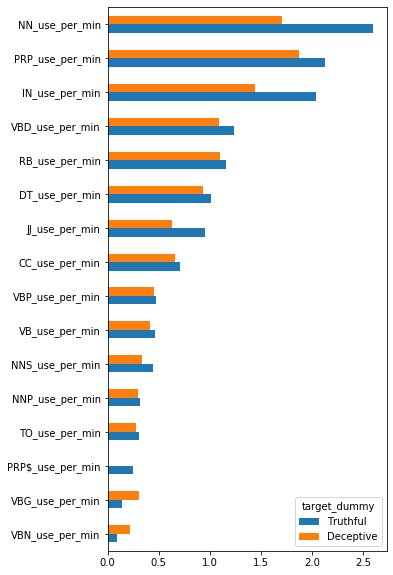

In [853]:
#Lets have a look at the median POS use per minute broken down by target.
df_lexical.groupby(by='target_dummy')[pos_columns_use_per_min].agg(np.median).T.rename(columns={0:'Truthful',1:'Deceptive'}).sort_values(by='Truthful').plot(kind='barh', figsize=(5,10),rot=0)

As can be see, the **largest** differences between truthful and deceptive statements are on noun (NN) use and Prepositions or subordinating conjunctions (IN), and Personal Pronouns (PRP) with truthful statements more associated with increased use of both. These difference in relative use aling with the notion of psychological distancing in that those being truthful will be drawing on actual conscious and subconsious recall of events. 

## POS Modelling
<img src="https://commongroundinternational.com/wp-content/uploads/2018/09/Parts-of-Speech-Same-Word-Different-Jobs.png" width="400" height="100">

Lets now trying modelling POS.

In [689]:
#First, lets create our dataframes for POS modelling
X_POS = df_lexical[pos_columns_use_per_min].copy()
y_POS = df_lexical.target_dummy.copy()

##### POS Modelling - Logistic Regression

In [690]:
#Try a logistic model. 
log_r_pos = LogisticRegression(random_state=random_state, max_iter=1000)
pipe_pos = make_pipeline(StandardScaler(),log_r_pos)

#####
params_log_r_pos = {'logisticregression__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100],\
                      'logisticregression__penalty': ['l1','l2','elasticnet'],\
                      'logisticregression__solver': ['liblinear']}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_log_r_pos = GridSearchCV(pipe_pos,params_log_r_pos,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_log_r_pos.fit(X_POS,y_POS)

# #8.3 And print out the best paramters to the screen
prediction_class_log_r_pos = grid_log_r_pos.predict(X_POS)
prediction_class_prob_log_r_pos = grid_log_r_pos.predict_proba(X_POS)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_log_r_pos = cross_val_score(grid_log_r_pos.best_estimator_, X_POS, y_POS, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_log_r_POS_loo = cv_scores_log_r_pos.copy()

classification_cv_log_r_POS_loo=pd.Series(classification_cv_log_r_POS_loo)
classification_cv_log_r_POS_loo[(classification_cv_log_r_POS_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r_POS_loo[(classification_cv_log_r_POS_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r_POS_loo[(classification_cv_log_r_POS_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r_POS_loo[(classification_cv_log_r_POS_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_log_r_pos.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.5s finished


Best paramters are:  {'logisticregression__C': 5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}


In [868]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_log_r_pos,'./pickled_models/POS_LR_pickle.joblib')

['./pickled_models/POS_LR_pickle.joblib']

In [691]:
print("POS - LOGISTIC REGRESSION - LOO")
print("---------------------------")
print("Best parameters are: ", grid_log_r_pos.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_POS.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_log_r_pos.mean())
print("Std CV score (using best parameters):", cv_scores_log_r_pos.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_log_r_pos))
print("\nClassification report\n",classification_report(classification_cv_log_r_POS_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r_POS_loo.values,y_POS))

POS - LOGISTIC REGRESSION - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 5, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.5543478260869565
Std CV score (using best parameters): 0.49703753761624675

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.71      0.83        62
         1.0       0.62      1.00      0.77        30

    accuracy                           0.80        92
   macro avg       0.81      0.85      0.80        92
weighted avg       0.88      0.80      0.81        92


Confusion Matrix
 [[44 18]
 [ 0 30]]


Text(0.7, 0.1, 'AUC:0.78')

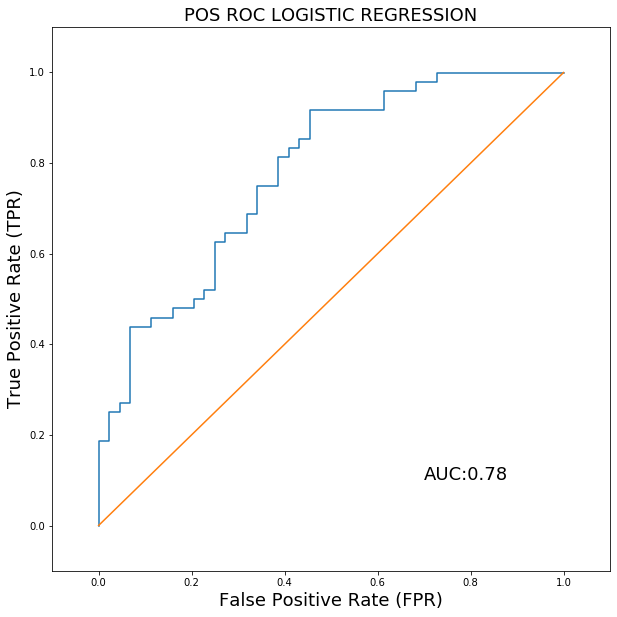

In [692]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_log_r_pos[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('POS ROC LOGISTIC REGRESSION', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

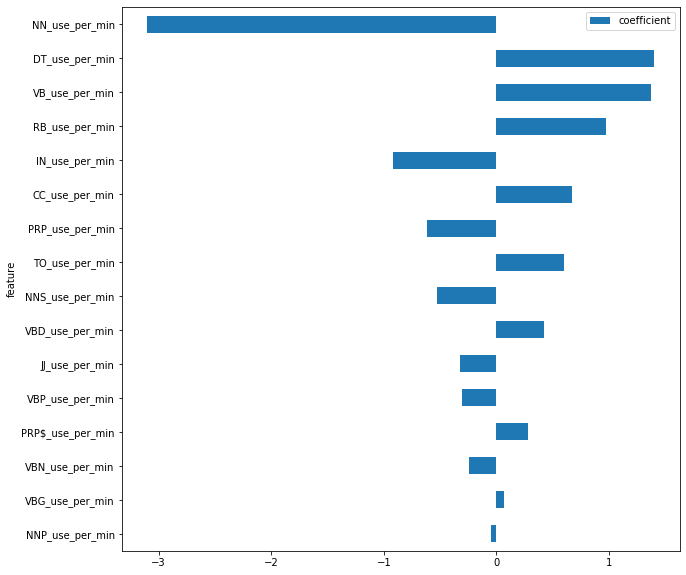

In [693]:
log_r__pos_coef = pd.DataFrame(grid_log_r_pos.best_estimator_[-1]\
             .coef_[0],X_POS.columns)\
             .rename(columns={0:'coefficient'}).reset_index().rename(columns={'index':'feature'})\

log_r__pos_coef['abs_coefficient'] = abs(log_r__pos_coef.coefficient)
log_r__pos_coef.sort_values(by='abs_coefficient', ascending=True).plot.barh(x='feature',y='coefficient', figsize=(10,10))

##### POS - Random Forest

In [694]:
#Now lets look at how a Random Forest performs
rf_pos = RandomForestClassifier(random_state=random_state)
pipe_rf_pos = make_pipeline(StandardScaler(),rf_pos)

#####
params_rf_pos = {'randomforestclassifier__max_depth':[2,3,4,5],\
                   'randomforestclassifier__criterion': ['entropy','gini'],\
                   'randomforestclassifier__max_features': [3,4,5,6]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_rf_pos = GridSearchCV(pipe_rf_pos,params_rf_pos,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_rf_pos.fit(X_POS,y_POS)

# #8.3 And print out the best paramters to the screen
prediction_class_rf_pos = grid_rf_pos.predict(X_POS)
prediction_class_prob_rf_pos = grid_rf_pos.predict_proba(X_POS)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_rf_pos = cross_val_score(grid_rf_pos.best_estimator_, X_POS, y_POS, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_rf__pos_loo = cv_scores_rf_pos.copy()

classification_cv_rf__pos_loo=pd.Series(classification_cv_rf__pos_loo)
classification_cv_rf__pos_loo[(classification_cv_rf__pos_loo==0)&(y_gesture.values==0)] = 1
classification_cv_rf__pos_loo[(classification_cv_rf__pos_loo==0)&(y_gesture.values==1)] = 0
classification_cv_rf__pos_loo[(classification_cv_rf__pos_loo==1)&(y_gesture.values==0)] = 0
classification_cv_rf__pos_loo[(classification_cv_rf__pos_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_rf_pos.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    8.3s finished


Best paramters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 5}


In [867]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_rf_pos,'./pickled_models/POS_RF_pickle.joblib')

['./pickled_models/POS_RF_pickle.joblib']

In [695]:
print("POS - RANDOM FOREST - LOO")
print("---------------------------")
print("Best parameters are: ", grid_rf_pos.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_POS.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_rf_pos.mean())
print("Std CV score (using best parameters):", cv_scores_rf_pos.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_rf_pos))
print("\nClassification report\n",classification_report(classification_cv_rf__pos_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_rf__pos_loo.values,y_POS))

POS - RANDOM FOREST - LOO
---------------------------
Best parameters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 5}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.4782608695652174
Std CV score (using best parameters): 0.4995271866554808

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.70      0.82        63
         1.0       0.60      1.00      0.75        29

    accuracy                           0.79        92
   macro avg       0.80      0.85      0.79        92
weighted avg       0.88      0.79      0.80        92


Confusion Matrix
 [[44 19]
 [ 0 29]]


Text(0.7, 0.1, 'AUC:1.0')

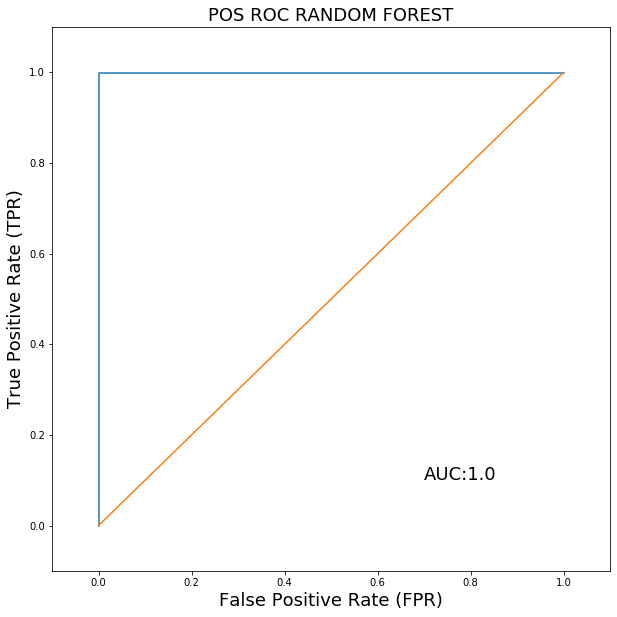

In [696]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_rf_pos[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('POS ROC RANDOM FOREST', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

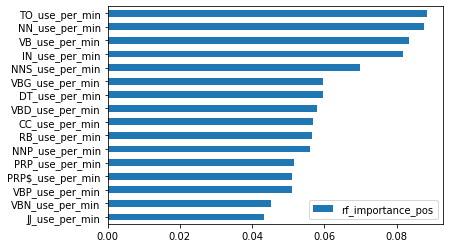

In [697]:
rf_pos_feat_importance = pd.DataFrame(grid_rf_pos.best_estimator_[-1].feature_importances_,\
                                        X_POS.columns)\
                                         .rename(columns={0:'rf_importance_pos'})\

rf_pos_feat_importance.sort_values(by='rf_importance_pos',\
                                     ascending=True)\
                                     .plot(kind='barh')

##### POS - SVM

In [698]:
#Finally, lets look at the performance of POS
svc_pos = SVC(probability=True)

pipe_pos_svc = make_pipeline(StandardScaler(),svc_pos)

# #####
params_pos_svc = {'svc__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,40,50,60,70,100],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf']}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_pos_svc = GridSearchCV(pipe_pos_svc,params_pos_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_pos_svc.fit(X_POS,y_POS)

# #8.3 And print out the best paramters to the screen
prediction_class_pos_svc = grid_pipe_pos_svc.predict(X_POS)
prediction_class_pos_prob_svc = grid_pipe_pos_svc.predict_proba(X_POS)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_pos_svc = cross_val_score(grid_pipe_pos_svc.best_estimator_, X_POS,y_POS, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_pos_svc_loo = cv_scores_pos_svc.copy()

classification_cv_pos_svc_loo=pd.Series(classification_cv_pos_svc_loo)
classification_cv_pos_svc_loo[(classification_cv_pos_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_pos_svc_loo[(classification_cv_pos_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_pos_svc_loo[(classification_cv_pos_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_pos_svc_loo[(classification_cv_pos_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_pos_svc.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    9.5s finished


Best paramters are:  {'svc__C': 20, 'svc__gamma': 0.0774263682681127, 'svc__kernel': 'rbf'}


In [866]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_pipe_pos_svc,'./pickled_models/POS_SVC_pickle.joblib')

['./pickled_models/POS_SVC_pickle.joblib']

In [699]:
print("POS - SVM - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_pos_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_POS.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_pos_svc.mean())
print("Std CV score (using best parameters):", cv_scores_pos_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_pos_svc))
print("\nClassification report\n",classification_report(classification_cv_pos_svc_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_pos_svc_loo.values,y_POS))

POS - SVM - LOO
---------------------------
Best parameters are:  {'svc__C': 20, 'svc__gamma': 0.0774263682681127, 'svc__kernel': 'rbf'}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.6195652173913043
Std CV score (using best parameters): 0.48549372682885417

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.80      0.89        55
         1.0       0.77      1.00      0.87        37

    accuracy                           0.88        92
   macro avg       0.89      0.90      0.88        92
weighted avg       0.91      0.88      0.88        92


Confusion Matrix
 [[44 11]
 [ 0 37]]


Text(0.7, 0.1, 'AUC:0.92')

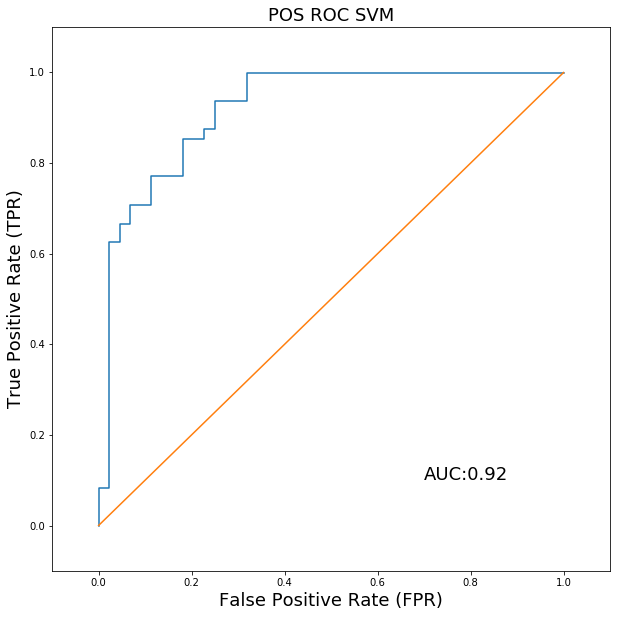

In [700]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_pos_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('POS ROC SVM', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

#### POS Model Performance Summary
Overall, the performance of the models are shown below in terms of Cross Validation scores, F1, and AUC

| Model | CV | CV Sd | F1 | AUC |
| --- | --- | --- | --- | --- |
| Random Forest | 0.48 | 0.50 | 0.79 | 1.00 |
| Logistic Regression | 0.55 | 0.50 | 0.80 | 0.78 |
| SVC | 0.62 | 0.49 | 0.88 | 0.92 |

As can be seen, SVC performed the best in terms of CV and so moves forward to the fusion model.

## Sentiment

<img src="https://www.translatemedia.com/wp-content/cache/thumbnails/2019/04/shutterstock_1073953772-860x9999.jpg" width="400" height="100">
As we also interested use of emotion, TextBlob also has a sentiment tool to extract sentiment. Sentiment is broken into polarity and subjectivity. 

* **Polarity:** is float which lies in the range of -1 to 1 where 1 means positive statement and -1 means a negative statement. 
* **Subjectivity:** is a measure of the degree to which a sentence contains personal opinion, emotion or judgment whereas objective refers to factual information. Highly levels Subjectivity is also a float which lies in the range of 0 to 1.

To achieve this, I will again use TextBlob, which has a sentiment module (.sentiment). 

In [701]:
#Create a dictionary of Sentiment (polarity and subjectivity) to append to original lexical dataframe
sentiment_dict = {}

for i,x in enumerate(X_lexical):
    textblob_sent = TextBlob(x)
    sentiment_dict.update({X_lexical.index[i]:{'polarity': textblob_sent.sentiment[0],
                        'subjectivity': textblob_sent.sentiment[1]}})

#Create a sentiment dataframe from the newly created dictionary
sent_df = pd.DataFrame.from_dict(sentiment_dict, orient='index')

#And then conctenate the lexical and pos_df dataframes
df_lexical = pd.concat([df_lexical,sent_df], axis=1)

In [702]:
#Create a dictionary of Sentiment (polarity and subjectivity) to append to original lexical dataframe
sentiment_dict_test = {}

for i,x in enumerate(X_lexical_test):
    textblob_sent = TextBlob(x)
    sentiment_dict_test.update({X_lexical_test.index[i]:{'polarity': textblob_sent.sentiment[0],
                        'subjectivity': textblob_sent.sentiment[1]}})

#Create a sentiment dataframe from the newly created dictionary
sent_df_test = pd.DataFrame.from_dict(sentiment_dict_test, orient='index')

# #And then conctenate the lexical and pos_df dataframes
df_lexical_test = pd.concat([df_lexical_test,sent_df_test], axis=1)

In [703]:
#To make things easier, lets create a list of the sentiment columns to work with. 
sentiment_columns = ['polarity', 'subjectivity']

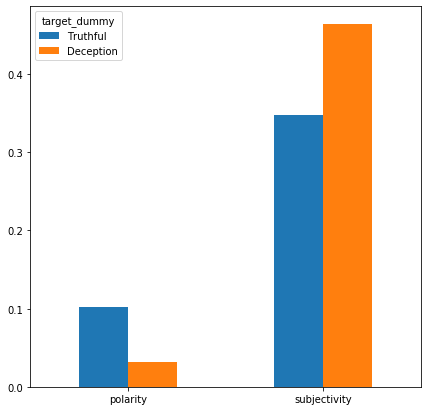

In [855]:
#Lets have a look at the median sentiment between trutuful and deceptive statments
df_lexical.groupby(by='target_dummy')[sentiment_columns].agg(np.median).T.rename(columns={0:'Truthful',1:'Deception'}).sort_values(by='Truthful').plot(kind='bar', figsize=(7,7),rot=0)
#As can be seen, trutful statements tend to be slightly more positive while deceptive statements tend 
#to have higher levels of subjectiveity indicating highers levels of personal opinion, emotion, or judgement (vs. factual)
#These results align to what we may expect in terms of emotional distancing when being deceptive. Specifically, 
#that those who are deceptive are more likely to use negative terminology (as suggested by lower polarity).
#We may also expect that a lie that represents something that factually didn't occur, would result in higher
#levels of subjectivity as shown by higher subjectivity for those who are deceptive. 

In [814]:
#Lets look also at some descriptive stats for sentiment by our target classes. 
df_lexical.groupby(by='target_dummy')[sentiment_columns].describe().T.rename(columns={0:"Truthful",1:"Deceptive"})

target_dummy         Truthful  Deceptive
polarity     count  44.000000  48.000000
             mean    0.118745   0.052689
             std     0.191800   0.218670
             min    -0.250000  -0.700000
             25%     0.000000  -0.001128
             50%     0.102083   0.032292
             75%     0.241071   0.161935
             max     0.648438   0.442857
subjectivity count  44.000000  48.000000
             mean    0.375372   0.452381
             std     0.194482   0.233567
             min     0.000000   0.000000
             25%     0.274901   0.348958
             50%     0.347222   0.463414
             75%     0.517299   0.666667
             max     0.783854   0.900000

### Sentiment Modelling
Lets now try modelling sentiment.

In [856]:
#First I will create my training and testing set. 
X_sentiment = df_lexical[sentiment_columns]
y_sentiment = df_lexical.target_dummy.copy()

#### Logistic Regression

In [706]:
log_r_sentiment = LogisticRegression(random_state=random_state, max_iter=1000)
pipe_sentiment = make_pipeline(StandardScaler(),log_r_sentiment)

#####
params_log_r_sentiment = {'logisticregression__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,50,100],\
                      'logisticregression__penalty': ['l1','l2','elasticnet'],\
                      'logisticregression__solver': ['liblinear']}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_log_r_sentiment = GridSearchCV(pipe_sentiment,params_log_r_sentiment,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_log_r_sentiment.fit(X_sentiment,y_sentiment)

# #8.3 And print out the best paramters to the screen
prediction_class_log_r_sentiment = grid_log_r_sentiment.predict(X_sentiment)
prediction_class_prob_log_r_sentiment = grid_log_r_sentiment.predict_proba(X_sentiment)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_log_r_sentiment = cross_val_score(grid_log_r_sentiment.best_estimator_, X_sentiment, y_sentiment, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_log_r_sentiment_loo = cv_scores_log_r_sentiment.copy()

classification_cv_log_r_sentiment_loo=pd.Series(classification_cv_log_r_sentiment_loo)
classification_cv_log_r_sentiment_loo[(classification_cv_log_r_sentiment_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r_sentiment_loo[(classification_cv_log_r_sentiment_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r_sentiment_loo[(classification_cv_log_r_sentiment_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r_sentiment_loo[(classification_cv_log_r_sentiment_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_log_r_sentiment.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    0.5s finished


Best paramters are:  {'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


In [865]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_log_r_sentiment,'./pickled_models/SENTIMENT_LR_pickle.joblib')

['./pickled_models/SENTIMENT_LR_pickle.joblib']

In [707]:
print("SENTIMENT - LOGISTIC - LOO")
print("---------------------------")
print("Best parameters are: ", grid_log_r_sentiment.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_sentiment.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_log_r_sentiment.mean())
print("Std CV score (using best parameters):", cv_scores_log_r_sentiment.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_log_r_sentiment))
print("\nClassification report\n",classification_report(classification_cv_log_r_sentiment_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r_sentiment_loo.values,y_POS))

SENTIMENT - LOGISTIC - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.5760869565217391
Std CV score (using best parameters): 0.49417686615953504

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.71      0.83        62
         1.0       0.62      1.00      0.77        30

    accuracy                           0.80        92
   macro avg       0.81      0.85      0.80        92
weighted avg       0.88      0.80      0.81        92


Confusion Matrix
 [[44 18]
 [ 0 30]]


Text(0.7, 0.1, 'AUC:0.625')

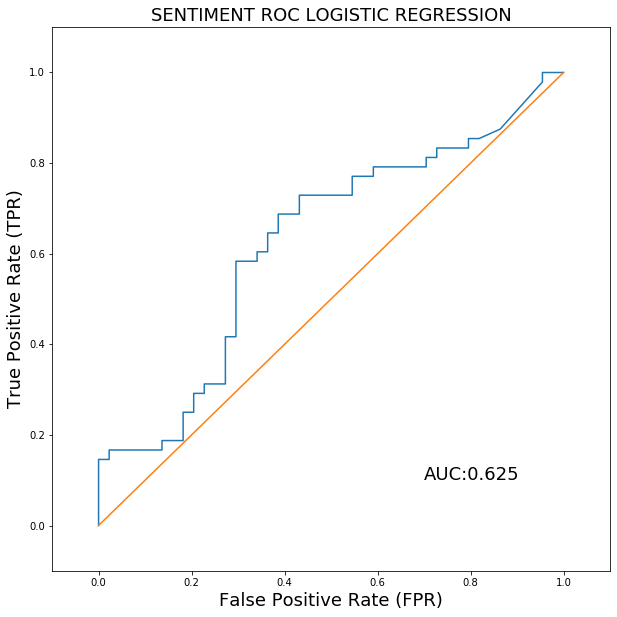

In [708]:
#To help visualise the performance of the logstic regression model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_log_r_sentiment[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('SENTIMENT ROC LOGISTIC REGRESSION', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

#### SVM

In [709]:
svc_sentiment = SVC(probability=True)

pipe_sentiment_svc = make_pipeline(StandardScaler(),svc_sentiment)

# #####
params_sentiment_svc = {'svc__C': [.0001,.001,.01,.05, .1,.12,.13,.135,.15,.16,.17,1,3,5,10,20,40,50,60,70,100],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf']}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_sentiment_svc = GridSearchCV(pipe_sentiment_svc,params_sentiment_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_sentiment_svc.fit(X_sentiment,y_sentiment)

# #8.3 And print out the best paramters to the screen
prediction_class_sentiment_svc = grid_pipe_sentiment_svc.predict(X_sentiment)
prediction_class_sentiment_prob_svc = grid_pipe_sentiment_svc.predict_proba(X_sentiment)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_sentiment_svc = cross_val_score(grid_pipe_sentiment_svc.best_estimator_, X_sentiment,y_sentiment, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_sentiment_svc_loo = cv_scores_sentiment_svc.copy()

classification_cv_sentiment_svc_loo=pd.Series(classification_cv_sentiment_svc_loo)
classification_cv_sentiment_svc_loo[(classification_cv_sentiment_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_sentiment_svc_loo[(classification_cv_sentiment_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_sentiment_svc_loo[(classification_cv_sentiment_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_sentiment_svc_loo[(classification_cv_sentiment_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_sentiment_svc.best_params_)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    4.9s finished


Best paramters are:  {'svc__C': 3, 'svc__gamma': 16.68100537200059, 'svc__kernel': 'rbf'}


In [864]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_pipe_sentiment_svc,'./pickled_models/SENTIMENT_SVC_pickle.joblib')

['./pickled_models/SENTIMENT_SVC_pickle.joblib']

In [710]:
print("SENTIMENT - SVM - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_sentiment_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_sentiment.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_sentiment_svc.mean())
print("Std CV score (using best parameters):", cv_scores_sentiment_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_sentiment_svc))
print("\nClassification report\n",classification_report(classification_cv_sentiment_svc_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_sentiment_svc_loo.values,y_POS))

SENTIMENT - SVM - LOO
---------------------------
Best parameters are:  {'svc__C': 3, 'svc__gamma': 16.68100537200059, 'svc__kernel': 'rbf'}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.6630434782608695
Std CV score (using best parameters): 0.47266988924258474

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.72      0.84        61
         1.0       0.65      1.00      0.78        31

    accuracy                           0.82        92
   macro avg       0.82      0.86      0.81        92
weighted avg       0.88      0.82      0.82        92


Confusion Matrix
 [[44 17]
 [ 0 31]]


Text(0.7, 0.1, 'AUC:0.917')

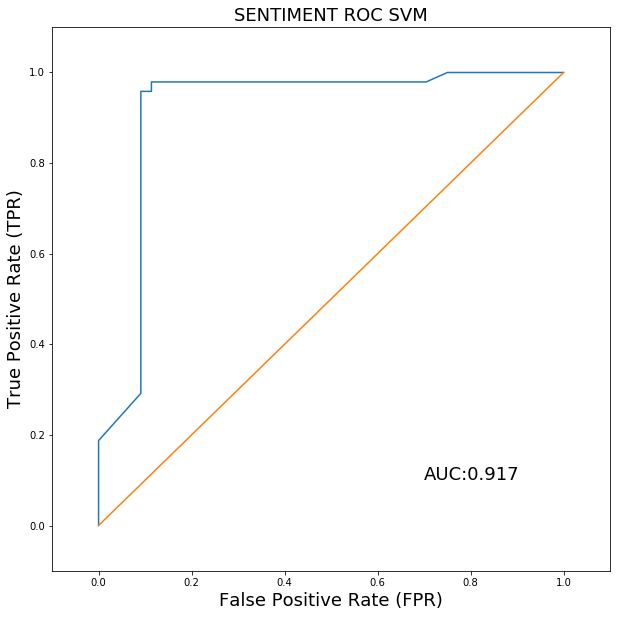

In [711]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_sentiment_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('SENTIMENT ROC SVM', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

#### Random Forests

In [712]:
#And lets have a look also at Random Forest
rf_sentiment = RandomForestClassifier(random_state=random_state)
pipe_rf_sentiment = make_pipeline(StandardScaler(),rf_sentiment)

#####
params_rf_sentiment = {'randomforestclassifier__max_depth':[1,2],\
                   'randomforestclassifier__criterion': ['entropy','gini'],\
                   'randomforestclassifier__max_features': [1,2]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_rf_sentiment = GridSearchCV(pipe_rf_sentiment,params_rf_sentiment,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_rf_sentiment.fit(X_sentiment,y_sentiment)

# #8.3 And print out the best paramters to the screen
prediction_class_rf_sentiment = grid_rf_sentiment.predict(X_sentiment)
prediction_class_prob_rf_sentiment = grid_rf_sentiment.predict_proba(X_sentiment)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_rf_sentiment = cross_val_score(grid_rf_sentiment.best_estimator_, X_sentiment,y_sentiment, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_rf__sentiment_loo = cv_scores_rf_sentiment.copy()

classification_cv_rf__sentiment_loo=pd.Series(classification_cv_rf__sentiment_loo)
classification_cv_rf__sentiment_loo[(classification_cv_rf__sentiment_loo==0)&(y_gesture.values==0)] = 1
classification_cv_rf__sentiment_loo[(classification_cv_rf__sentiment_loo==0)&(y_gesture.values==1)] = 0
classification_cv_rf__sentiment_loo[(classification_cv_rf__sentiment_loo==1)&(y_gesture.values==0)] = 0
classification_cv_rf__sentiment_loo[(classification_cv_rf__sentiment_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_rf_sentiment.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.1s finished


Best paramters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 1}


In [863]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_rf_sentiment,'./pickled_models/SENTIMENT_RF_pickle.joblib')

['./pickled_models/SENTIMENT_RF_pickle.joblib']

In [713]:
print("SENTIMENT - RANDOM FORESTS - LOO")
print("---------------------------")
print("Best parameters are: ", grid_rf_sentiment.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_sentiment.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_rf_sentiment.mean())
print("Std CV score (using best parameters):", cv_scores_rf_sentiment.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_rf_sentiment))
print("\nClassification report\n",classification_report(classification_cv_rf__sentiment_loo.values,y_POS))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_rf__sentiment_loo.values,y_POS))

SENTIMENT - RANDOM FORESTS - LOO
---------------------------
Best parameters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 1}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.5217391304347826
Std CV score (using best parameters): 0.4995271866554807

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.75      0.85        59
         1.0       0.69      1.00      0.81        33

    accuracy                           0.84        92
   macro avg       0.84      0.87      0.83        92
weighted avg       0.89      0.84      0.84        92


Confusion Matrix
 [[44 15]
 [ 0 33]]


Text(0.7, 0.1, 'AUC:0.743')

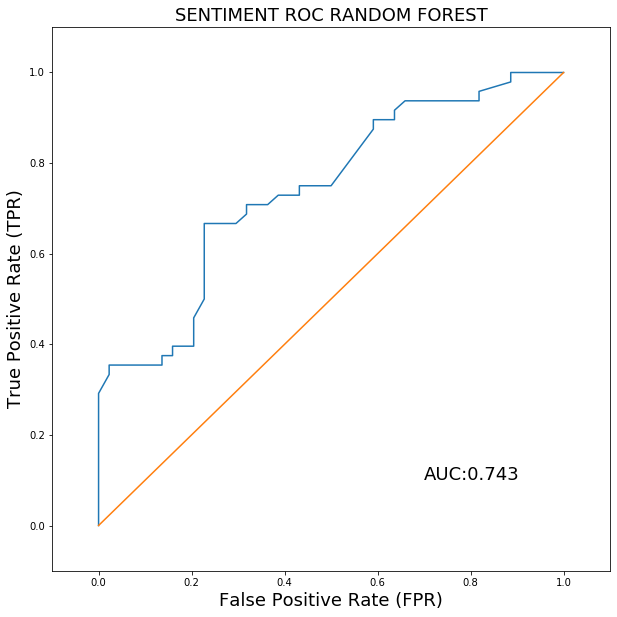

In [714]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_rf_sentiment[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('SENTIMENT ROC RANDOM FOREST', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

#### Sentiment Model Performance Summary
Overall, the performance of the models are shown below in terms of Cross Validation scores, F1, and AUC

| Model | CV | CV Sd | F1 | AUC |
| --- | --- | --- | --- | --- |
| Random Forest | 0.52 | 0.50 | 0.84 | 0.74 |
| Logistic Regression | 0.58 | 0.49 | 0.80 | 0.63 |
| SVC | 0.66 | 0.47 | 0.82 | 0.92 |

As can be seen, SVC performed the best in terms of CV and so moves forward to the fusion model.

### Bag of Words
<img src="https://i2.wp.com/datameetsmedia.com/staging/3908/wp-content/uploads/2017/05/bagofwords.004.jpeg?resize=800%2C203" width="700" height="100">



Finally, lets look at the bag of words (BAG) model.


In [715]:
#Lets create our X and y dataframes
X_bow = df_lexical['transcription']
y_bow = df_lexical.target_dummy

In [716]:
#Lets specfy our stop words for use. 
standard_stop_words = [] #list(list(ENGLISH_STOP_WORDS) + list(punctuation))

bespoke_stop_words = ['t','d']

final_stop_words = standard_stop_words + bespoke_stop_words


# lexical_tfid = TfidfVectorizer(stop_words=final_stop_words,
#                                ngram_range=(1, 3),
#                                lowercase=True,
#                                token_pattern='\w+',
#                                max_df=109, #<--Max document frequency selected based on size of deceptive class
#                                min_df=4
#                                )

# lexical_tfid_word_matrix = lexical_tfid.fit_transform(df_lexical['bag_of_words'])

# df_lexical_tfid_word_matrix = pd.DataFrame(lexical_tfid_word_matrix.toarray(),columns=lexical_tfid.get_feature_names())

##### Bag of Words Modelling - Logistic Regression

In [717]:
#Lets first try a logstic regression model
log_reg_bag = LogisticRegression()
tru_SVD_bag  = TruncatedSVD()
bag_tfid = TfidfVectorizer(stop_words=final_stop_words)

pipe_bag_log_r = make_pipeline(bag_tfid,tru_SVD_bag,log_reg_bag)

# #####
params_bag_log_r = {'truncatedsvd__n_components': [5,7,10,12],\
                        'logisticregression__C': [.1,.12,.13,.135,.15,.16,.17,1,3,5,10,11,15],\
                        'tfidfvectorizer__ngram_range': [(1,1),(1,2),(1,3)],\
                        'tfidfvectorizer__min_df': [5,7],\
                        'tfidfvectorizer__max_df': [70,80,90],\
                        'tfidfvectorizer__max_features': [100,125,150,175,200]}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_bag_log_r = GridSearchCV(pipe_bag_log_r,params_bag_log_r,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_bag_log_r.fit(X_bow,y_bow)

# #8.3 And print out the best paramters to the screen
prediction_class_bag_log_r = grid_pipe_bag_log_r.predict(X_bow)
prediction_class_bag_prob_log_r = grid_pipe_bag_log_r.predict_proba(X_bow)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_bag_log_r = cross_val_score(grid_pipe_bag_log_r.best_estimator_, X_bow,y_bow, cv=loo)

classification_cv_log_r_bag_loo = cv_scores_bag_log_r.copy()

classification_cv_log_r_bag_loo=pd.Series(classification_cv_log_r_bag_loo)
classification_cv_log_r_bag_loo[(classification_cv_log_r_bag_loo==0)&(y_gesture.values==0)] = 1
classification_cv_log_r_bag_loo[(classification_cv_log_r_bag_loo==0)&(y_gesture.values==1)] = 0
classification_cv_log_r_bag_loo[(classification_cv_log_r_bag_loo==1)&(y_gesture.values==0)] = 0
classification_cv_log_r_bag_loo[(classification_cv_log_r_bag_loo==1)&(y_gesture.values==1)] = 1

print("Best parameters are: ", grid_pipe_bag_log_r.best_params_)

Fitting 5 folds for each of 4680 candidates, totalling 23400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 6000 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done 9600 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 14000 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 19200 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 23400 out of 23400 | elapsed:  4.0min finished


Best parameters are:  {'logisticregression__C': 3, 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 7, 'tfidfvectorizer__ngram_range': (1, 1), 'truncatedsvd__n_components': 5}


In [862]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_pipe_bag_log_r,'./pickled_models/BAG_LR_pickle.joblib')

['./pickled_models/BAG_LR_pickle.joblib']

In [718]:
print("BAG OF WORDS - LOGISTIC REGRESSION MODEL - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_bag_log_r.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_bow.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_bag_log_r.mean())
print("Std CV score (using best parameters):", cv_scores_bag_log_r.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_vocal_svc))
print("\nClassification report\n",classification_report(classification_cv_log_r_bag_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_log_r_bag_loo.values,y_vocal))

BAG OF WORDS - LOGISTIC REGRESSION MODEL - LOO
---------------------------
Best parameters are:  {'logisticregression__C': 3, 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 7, 'tfidfvectorizer__ngram_range': (1, 1), 'truncatedsvd__n_components': 5}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.5760869565217391
Std CV score (using best parameters): 0.494176866159535

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.73      0.85        60
         1.0       0.67      1.00      0.80        32

    accuracy                           0.83        92
   macro avg       0.83      0.87      0.82        92
weighted avg       0.88      0.83      0.83        92


Confusion Matrix
 [[44 16]
 [ 0 32]]


Text(0.7, 0.1, 'AUC:0.725')

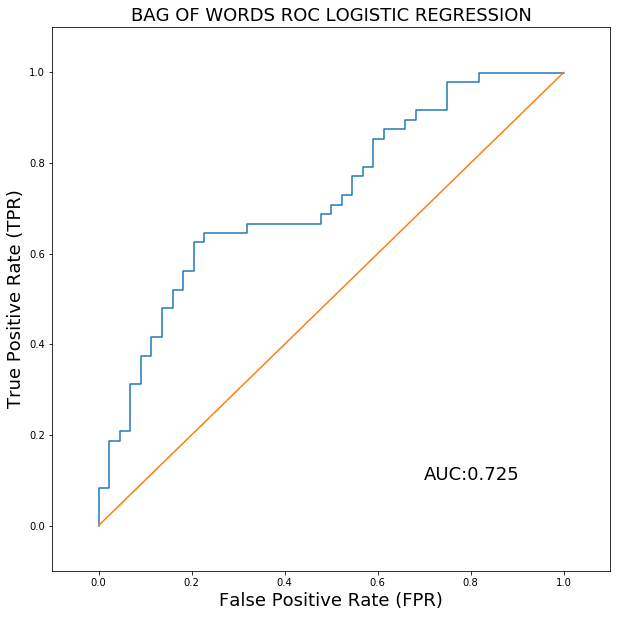

In [719]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_bag_prob_log_r[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('BAG OF WORDS ROC LOGISTIC REGRESSION', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

##### Bag of Words Modelling - Random Forests

In [720]:
#First, lets have a look at the performance for using LeaveOneOut on the entire data-set
rf_bag = RandomForestClassifier(random_state=random_state)
tru_SVD_bag_rf  = TruncatedSVD()
bag_tfid_rf = TfidfVectorizer(stop_words=final_stop_words)

pipe_rf_bag = make_pipeline(bag_tfid_rf,tru_SVD_bag_rf,rf_bag)

#####
params_rf_bag = {'truncatedsvd__n_components': [5,7,10],\
                 'randomforestclassifier__max_depth':[1,2],\
                 'randomforestclassifier__criterion': ['entropy','gini'],\
                 'randomforestclassifier__max_features': [1,2],
                 'tfidfvectorizer__ngram_range': [(1,1),(1,2)],\
                 'tfidfvectorizer__min_df': [5,7],\
                 'tfidfvectorizer__max_df': [70,100],\
                 'tfidfvectorizer__max_features': [125,150]}

# # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_rf_bag = GridSearchCV(pipe_rf_bag,params_rf_bag,verbose=1,n_jobs=-1)

# #8.2. Fit the gridsearch to the training data
grid_rf_bag.fit(X_bow,y_bow)

# #8.3 And print out the best paramters to the screen
prediction_class_rf_bag = grid_rf_bag.predict(X_bow)
prediction_class_prob_rf_bag = grid_rf_bag.predict_proba(X_bow)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_rf_bag = cross_val_score(grid_rf_bag.best_estimator_,X_bow,y_bow, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_rf__bag_loo = cv_scores_rf_bag.copy()

classification_cv_rf__bag_loo=pd.Series(classification_cv_rf__bag_loo)
classification_cv_rf__bag_loo[(classification_cv_rf__bag_loo==0)&(y_gesture.values==0)] = 1
classification_cv_rf__bag_loo[(classification_cv_rf__bag_loo==0)&(y_gesture.values==1)] = 0
classification_cv_rf__bag_loo[(classification_cv_rf__bag_loo==1)&(y_gesture.values==0)] = 0
classification_cv_rf__bag_loo[(classification_cv_rf__bag_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_rf_bag.best_params_)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  2.1min finished


Best paramters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 2, 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 7, 'tfidfvectorizer__ngram_range': (1, 1), 'truncatedsvd__n_components': 7}


In [861]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_rf_bag,'./pickled_models/BAG_RF_pickle.joblib')

['./pickled_models/BAG_RF_pickle.joblib']

In [721]:
print("BAG OF WORDS - RANDOM FORESTS - LOO")
print("---------------------------")
print("Best parameters are: ", grid_rf_bag.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_bow.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_rf_bag.mean())
print("Std CV score (using best parameters):", cv_scores_rf_bag.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_rf_bag))
print("\nClassification report\n",classification_report(classification_cv_rf__bag_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_rf__bag_loo.values,y_vocal))

BAG OF WORDS - RANDOM FORESTS - LOO
---------------------------
Best parameters are:  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 2, 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 7, 'tfidfvectorizer__ngram_range': (1, 1), 'truncatedsvd__n_components': 7}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.5760869565217391
Std CV score (using best parameters): 0.494176866159535

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95        49
         1.0       0.90      1.00      0.95        43

    accuracy                           0.95        92
   macro avg       0.95      0.95      0.95        92
weighted avg       0.95      0.95      0.95   

Text(0.7, 0.1, 'AUC:0.86')

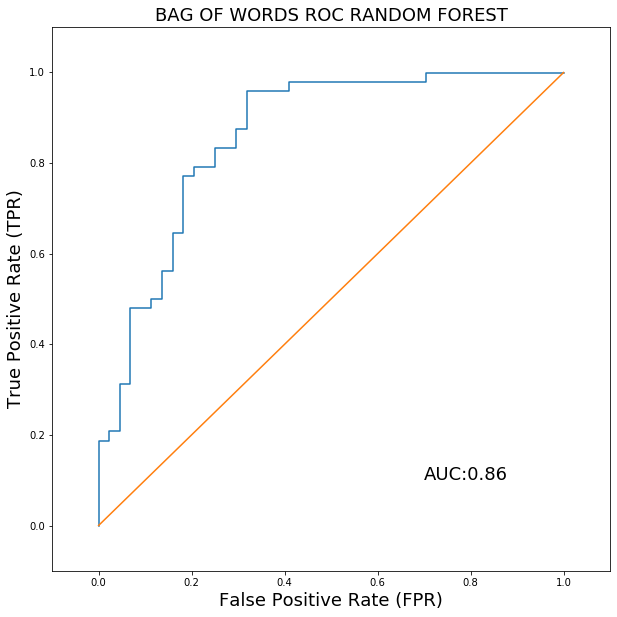

In [722]:
#To help visualise the performance of the random forest model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_prob_rf_bag[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('BAG OF WORDS ROC RANDOM FOREST', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

##### Bag of Words Modelling - SVM

In [723]:
svc_bag = SVC(probability=True)
tru_SVD_bag_svc  = TruncatedSVD()
bag_tfid_svc = TfidfVectorizer(stop_words=final_stop_words)

pipe_bag_svc = make_pipeline(bag_tfid_svc,tru_SVD_bag_svc,svc_bag)

# #####
params_bag_svc = {'truncatedsvd__n_components': [5,7,20],\
              'svc__C': [.001,.17,1,3],\
              'svc__gamma':np.logspace(-5, 2, 10),\
              'svc__kernel': ['linear','rbf'],
              'tfidfvectorizer__ngram_range': [(1,1),(1,2)],\
              'tfidfvectorizer__min_df': [5,7],\
              'tfidfvectorizer__max_df': [70,90],\
              'tfidfvectorizer__max_features': [150]}

# # # Set up a gridsearch with above parameters to pass to the pipe pipeline
grid_pipe_bag_svc = GridSearchCV(pipe_bag_svc,params_bag_svc,verbose=1,n_jobs=-1)

# #8.2. Fit the grid_pipe to the training data
grid_pipe_bag_svc.fit(X_bow,y_bow)

# #8.3 And print out the best paramters to the screen
prediction_class_bag_svc = grid_pipe_bag_svc.predict(X_bow)
prediction_class_bag_prob_svc = grid_pipe_bag_svc.predict_proba(X_bow)

# #Calculate cv scores using leave one out (loo) for on whole data set
cv_scores_bag_svc = cross_val_score(grid_pipe_bag_svc.best_estimator_, X_bow,y_bow, cv=loo)

# #To see how accurate our predictions are, as we are using LOO and is a binary target,
# #we need to specify those cases when the model correctly classified the target and those
# #when it did not in order to calculate the accuracy and generate the confusion matrix
classification_cv_bag_svc_loo = cv_scores_bag_svc.copy()

classification_cv_bag_svc_loo=pd.Series(classification_cv_bag_svc_loo)
classification_cv_bag_svc_loo[(classification_cv_bag_svc_loo==0)&(y_gesture.values==0)] = 1
classification_cv_bag_svc_loo[(classification_cv_bag_svc_loo==0)&(y_gesture.values==1)] = 0
classification_cv_bag_svc_loo[(classification_cv_bag_svc_loo==1)&(y_gesture.values==0)] = 0
classification_cv_bag_svc_loo[(classification_cv_bag_svc_loo==1)&(y_gesture.values==1)] = 1

print("Best paramters are: ", grid_pipe_bag_svc.best_params_)

Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 7056 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9600 out of 9600 | elapsed:  1.5min finished


Best paramters are:  {'svc__C': 1, 'svc__gamma': 16.68100537200059, 'svc__kernel': 'rbf', 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 1), 'truncatedsvd__n_components': 7}


In [859]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(grid_pipe_bag_svc,'./pickled_models/BAG_SVC_pickle.joblib')

['./pickled_models/BAG_SVC_pickle.joblib']

In [724]:
print("BAG OF WORDS - SVC - LOO")
print("---------------------------")
print("Best parameters are: ", grid_pipe_bag_svc.best_params_)

print("\n*****************")
print("\nPercent of largest class (baseline):", y_bow.value_counts(normalize=True).max())
print("Average CV score (using best parameters):", cv_scores_bag_svc.mean())
print("Std CV score (using best parameters):", cv_scores_bag_svc.std())

print("\nPerformance across models on LOO case")
print("*****************")
print('\nHoldout set size', len(prediction_class_bag_svc))
print("\nClassification report\n",classification_report(classification_cv_bag_svc_loo.values,y_vocal))
print("\nConfusion Matrix\n",confusion_matrix(classification_cv_bag_svc_loo.values,y_vocal))

BAG OF WORDS - SVC - LOO
---------------------------
Best parameters are:  {'svc__C': 1, 'svc__gamma': 16.68100537200059, 'svc__kernel': 'rbf', 'tfidfvectorizer__max_df': 70, 'tfidfvectorizer__max_features': 150, 'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 1), 'truncatedsvd__n_components': 7}

*****************

Percent of largest class (baseline): 0.5217391304347826
Average CV score (using best parameters): 0.6739130434782609
Std CV score (using best parameters): 0.4687795359314745

Performance across models on LOO case
*****************

Holdout set size 92

Classification report
               precision    recall  f1-score   support

         0.0       1.00      0.81      0.90        54
         1.0       0.79      1.00      0.88        38

    accuracy                           0.89        92
   macro avg       0.90      0.91      0.89        92
weighted avg       0.91      0.89      0.89        92


Confusion Matrix
 [[44 10]
 [ 0 38]]


Text(0.7, 0.1, 'AUC:0.997')

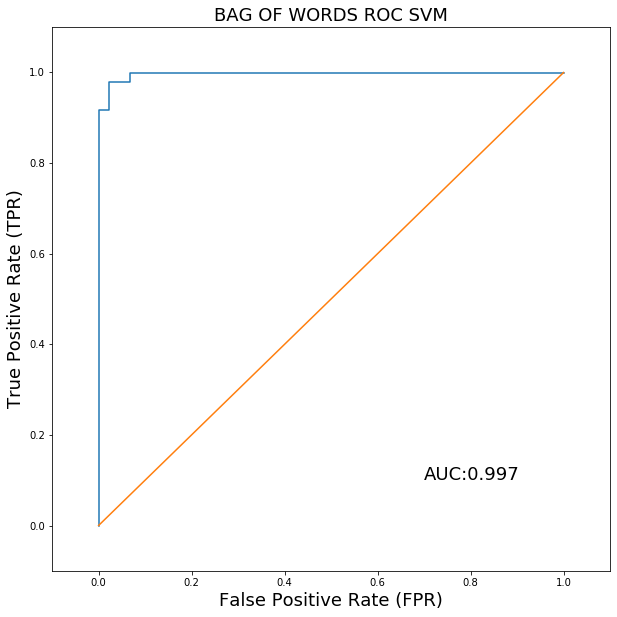

In [725]:
#To help visualise the performance of the SVC, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_gesture, prediction_class_bag_prob_svc[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('BAG OF WORDS ROC SVM', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

#### Bag of Words (BAG) Model Performance Summary
Overall, the performance of the models are shown below in terms of Cross Validation scores, F1, and AUC

| Model | CV | CV Sd | F1 | AUC |
| --- | --- | --- | --- | --- |
| Random Forest | 0.58 | 0.49 | 0.95 | 0.86 |
| Logistic Regression | 0.58 | 0.49 | 0.83 | 0.73 |
| SVC | 0.67 | 0.47 | 0.89 | 0.99 |

As can be seen, SVC performed the best in terms of CV and so moves forward to the fusion model.

# Model Fusion
<img src="https://www.createdigital.org.au/wp-content/uploads/2019/01/fusion-3.jpg" width="400" height="100">


Now that each individual model has been trained, I will create fusion or ensemble models using hard and soft voting approaches.

##### Hard Voting Approach

In the hard voting approach, each of the individual models make their independent predictions for each case. These predictions are then tallied up as "votes" with the class with the highest number of votes selected as the final predicted class. 

This is represented in the image below. Here we have a new instance (i.e. a new set of observed featured) with the relevant features passed to the respective model for prediction. Each individual models prediction is then counted. In this case, three models have predicted 1 and one model has predicted 2. In this case, the majority vote wins and the final predicted in 1. 

<img src="https://i.stack.imgur.com/W7UmY.png" width="800" height="100">

##### Soft Voting Approach
In the soft voting approach, the predicted probability vectors of each models are summed and averaged. The class with the highest value will be the winner and is given as output. This is represented in the image below. In this case, the probabilities of of the five classifiers are summed and averaged. In this case, we find that class 2 has the highest overall probability across all five classifiers, which is ten used as the predicted class.

<img src="https://iq.opengenus.org/content/images/2020/01/ud382N9.png" width="800" height="100">


### Prediction Accuracy on Training Set
First, lets look at creating the fusion models on the training set. 

##### Fusion model - Hard Voting

In [817]:
#To simplify the predictions, lets create a new dataframe based on the best performing models (as assessed by CV).
#This first sets up all the predictions from the best individual models that were created above. 
predicted_fusion_training = pd.DataFrame(list(zip(df_original.target_dummy,prediction_class_svc,
                                                  prediction_class_rf_vocal,
                                                  prediction_class_pos_svc,
                                                  prediction_class_sentiment_svc,
                                                  prediction_class_bag_svc))).rename(columns={0:'target_true',
                                                    1:'gesture_predicted_class_SVC',
                                                    2:'vocal_predicted_class_rf',
                                                    3:'parts_of_speech_predicted_class_SVC',
                                                    4:'sentiment_predicted_class_SVC',
                                                    5:'bag_predicted_class_svc'})

#As we are first trying a hard voting strategy, lets add up all the predictions and divide by the total number of models (5)
predicted_fusion_training['average'] = (predicted_fusion_training['gesture_predicted_class_SVC'] +
                                            predicted_fusion_training['vocal_predicted_class_rf'] +
                                            predicted_fusion_training['parts_of_speech_predicted_class_SVC'] +
                                            predicted_fusion_training['sentiment_predicted_class_SVC'] +
                                            predicted_fusion_training['bag_predicted_class_svc'])/5

#This creates a new columns containing the predicted class based on the average class. 
#I have set the cut-off point at 0.5, with an average being classified as deceptive (1) and those less than 0.5 as 0.
predicted_fusion_training['fusion_predicted_class'] = predicted_fusion_training['average'].apply(lambda x:1 if x >0.50 else 0)

#Finally we print out the classification report and confusion matrix.
print(classification_report(predicted_fusion_training['target_true'],predicted_fusion_training['fusion_predicted_class']))
print(confusion_matrix(predicted_fusion_training['target_true'],predicted_fusion_training['fusion_predicted_class']))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.96      0.98      0.97        48

    accuracy                           0.97        92
   macro avg       0.97      0.97      0.97        92
weighted avg       0.97      0.97      0.97        92

[[42  2]
 [ 1 47]]


##### Fusion model - Soft Voting

In [727]:
#I also need to test the soft voting approach. 
#As we only have two classes, I take the probability from each individual model of each case belonging to the 
#deceptive class and put them into a dataframe along with the true target class. 
predicted_fusion_training_prob = pd.DataFrame(list(zip(df_original.target_dummy,
                                                      prediction_class_prob_svc[:,1],
                                                      prediction_class_prob_rf_vocal[:,1],
                                                      prediction_class_pos_prob_svc[:,1],
                                                      prediction_class_sentiment_prob_svc[:,1],
                                                      prediction_class_bag_prob_svc[:,1]))).rename(columns={0:'target_true',
                                                    1:'gesture_predicted_prob_SVC',
                                                    2:'vocal_predicted_prob_rf',
                                                    3:'parts_of_speech_predicted_prob_SVC',
                                                    4:'sentiment_predicted_prob_svc',
                                                    5:'bag_predicted_prob_svc'})

#Like in the hard voting approach, I take the average probability from each of the models and divide by the number of models
#to get an average probability
predicted_fusion_training_prob['average_prob'] = (predicted_fusion_training_prob['gesture_predicted_prob_SVC'] +
                                            predicted_fusion_training_prob['vocal_predicted_prob_rf'] +
                                            predicted_fusion_training_prob['parts_of_speech_predicted_prob_SVC'] +
                                            predicted_fusion_training_prob['sentiment_predicted_prob_svc'] +
                                            predicted_fusion_training_prob['bag_predicted_prob_svc'])/5

#Again, I have set the cut-off point at 0.5, with an average being classified as deceptive (1) and those less than 0.5 as 0.
predicted_fusion_training_prob['fusion_predicted_class'] = predicted_fusion_training_prob['average_prob'].apply(lambda x:1 if x >0.50 else 0)

print(classification_report(predicted_fusion_training_prob['target_true'],predicted_fusion_training_prob['fusion_predicted_class']))
print(confusion_matrix(predicted_fusion_training_prob['target_true'],predicted_fusion_training_prob['fusion_predicted_class']))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95        44
           1       0.94      0.98      0.96        48

    accuracy                           0.96        92
   macro avg       0.96      0.96      0.96        92
weighted avg       0.96      0.96      0.96        92

[[41  3]
 [ 1 47]]


Text(0.7, 0.1, 'AUC:0.997')

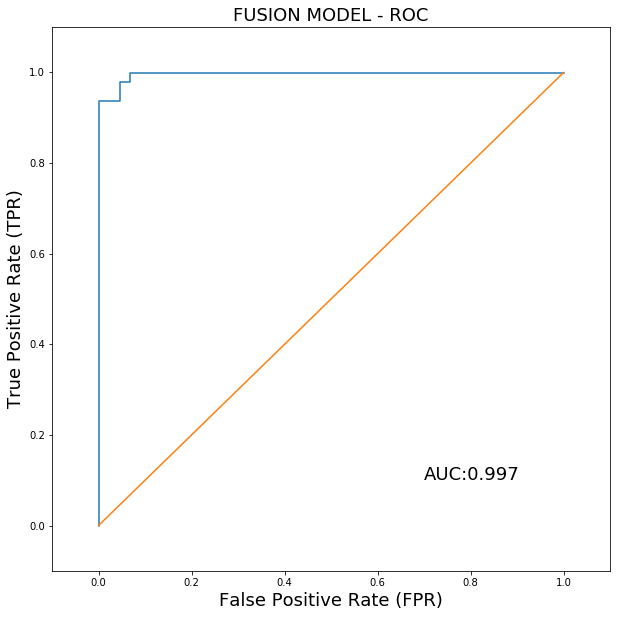

In [818]:
#To visualise the performance of the Fusion hard-voting model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(predicted_fusion_training_prob['target_true'], predicted_fusion_training_prob['average_prob'])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('FUSION MODEL - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

### Fusion Model Prediction Accuracy on Testing Set
Lets also look at how well the model performs on the test hold out set. Again, I will use both a hard and soft voting approach.

In [729]:
#Lets first create variables containing all the predictions and probabilities on each of the variables on the testing set.
#Predicting across each model for fusion
gesture_test_class_predictions = grid_pipe_svc.predict(df_original_test[gesture_variables])
gesture_test_prob_predictions = grid_pipe_svc.predict_proba(df_original_test[gesture_variables])
# #Vocal
vocal_test_class_predictions = grid_rf_vocal.predict(df_original_test[all_vocal_features])
vocal_test_prob_predictions = grid_rf_vocal.predict_proba(df_original_test[all_vocal_features])
# #Lexical – POS
pos_test_class_predictions = grid_pipe_pos_svc.predict(df_lexical_test[pos_columns_use_per_min])
pos_test_prob_predictions = grid_pipe_pos_svc.predict_proba(df_lexical_test[pos_columns_use_per_min])
# #Lexical – Sentiment
sentiment_test_class_predictions = grid_pipe_sentiment_svc.predict(df_lexical_test[sentiment_columns])
sentiment_test_prob_predictions = grid_pipe_sentiment_svc.predict_proba(df_lexical_test[sentiment_columns])
# #Lexical – Bag of Words
bag_test_class_predictions = grid_pipe_bag_svc.predict(df_lexical_test['transcription'])
bag_test_prob_predictions = grid_pipe_bag_svc.predict_proba(df_lexical_test['transcription'])

##### Hard Voting
First, lets look at the hard voting strategy.

In [730]:
#Here I create a new dataframe to easily work on for current purposes. 
fusion_predicted_class = pd.DataFrame(list(zip(df_original_test.target_dummy,
        gesture_test_class_predictions,
        vocal_test_class_predictions,
        pos_test_class_predictions,
        sentiment_test_class_predictions,
        bag_test_class_predictions))).rename(columns={0:'target_true',
                                                    1:'gesture_predicted_class_SVC',
                                                    2:'vocal_predicted_class_rf',
                                                    3:'parts_of_speech_predicted_class_SVC',
                                                    4:'sentiment_predicted_class_SVC',
                                                    5:'bag_predicted_class_SVC'})
#Again, I take the average class from each of the models and divide by the number of models
#to get an average class
fusion_predicted_class['average_class'] = (fusion_predicted_class['gesture_predicted_class_SVC'] +
                                            fusion_predicted_class['vocal_predicted_class_rf'] +
                                            fusion_predicted_class['parts_of_speech_predicted_class_SVC'] +
                                            fusion_predicted_class['sentiment_predicted_class_SVC'] +
                                            fusion_predicted_class['bag_predicted_class_SVC'])/5

#And then create the final predicted class based on the cut-off of 0.5 (>0.5 classified as deceptive)
fusion_predicted_class['fusion_predicted_class'] = fusion_predicted_class['average_class'].apply(lambda x:1 if x >0.5 else 0)

#Print out the classification report.
print(classification_report(fusion_predicted_class['target_true'],fusion_predicted_class['fusion_predicted_class']))
print(confusion_matrix(fusion_predicted_class['target_true'],fusion_predicted_class['fusion_predicted_class']))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.88      0.78      0.82         9

    accuracy                           0.82        17
   macro avg       0.83      0.83      0.82        17
weighted avg       0.83      0.82      0.82        17

[[7 1]
 [2 7]]


##### Soft Voting
And now lets look at the soft voting strategy.

In [731]:
#Create a new dataframe containing probabilities from each of the individual models of the deceptive class
fusion_predicted_prob = pd.DataFrame(list(zip(df_original_test.target_dummy,
        gesture_test_prob_predictions[:,1],
        vocal_test_prob_predictions[:,1],
        pos_test_prob_predictions[:,1],
        sentiment_test_prob_predictions[:,1],
        bag_test_prob_predictions[:,1]))).rename(columns={0:'target_true',
                                                    1:'gesture_predicted_prob_SVC',
                                                    2:'vocal_predicted_prob_rf',
                                                    3:'parts_of_speech_predicted_prob_SVC',
                                                    4:'sentiment_predicted_prob_SVC',
                                                    5:'bag_predicted_prob_SVC'})

#Calculate the average probability of belong to the deceptive class and divide by the number of models (5)
fusion_predicted_prob['average_prob'] = (fusion_predicted_prob['gesture_predicted_prob_SVC'] +
                                            fusion_predicted_prob['vocal_predicted_prob_rf'] +
                                            fusion_predicted_prob['parts_of_speech_predicted_prob_SVC'] +
                                            fusion_predicted_prob['sentiment_predicted_prob_SVC'] +
                                            fusion_predicted_prob['bag_predicted_prob_SVC'])/5

#And then create the final predicted class based on the cut-off of 0.5 (>0.5 classified as deceptive)
fusion_predicted_prob['fusion_predicted_class'] = fusion_predicted_prob['average_prob'].apply(lambda x:1 if x >0.50 else 0)

#And finally print out the classification report, which con
print(classification_report(fusion_predicted_prob['target_true'],fusion_predicted_prob['fusion_predicted_class']))
print(confusion_matrix(fusion_predicted_prob['target_true'],fusion_predicted_prob['fusion_predicted_class']))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.89      0.94         9

    accuracy                           0.94        17
   macro avg       0.94      0.94      0.94        17
weighted avg       0.95      0.94      0.94        17

[[8 0]
 [1 8]]


Text(0.7, 0.1, 'AUC:0.986')

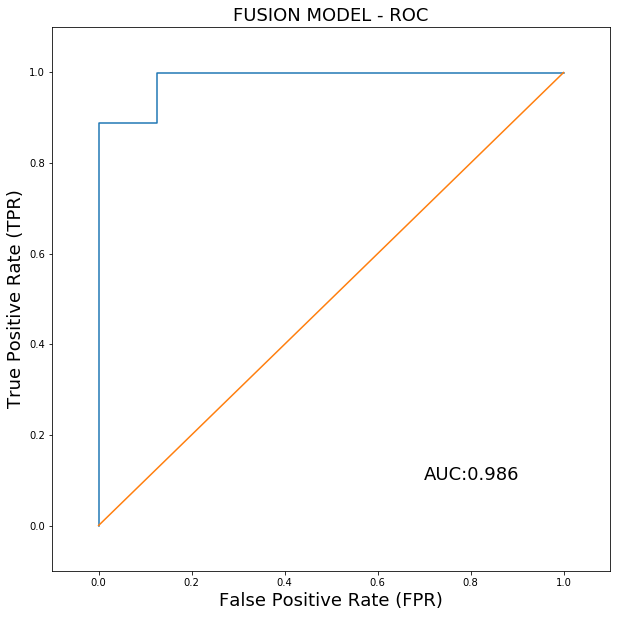

In [820]:
#To help visualise the performance of the soft voting model, lets plot the ROC curve
plt.figure(figsize=(10,10))
false_positive_rate, true_positive_rate, thresholds = roc_curve(fusion_predicted_prob['target_true'], fusion_predicted_prob['average_prob'])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1])
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('FUSION MODEL - ROC', fontsize=18)
plt.xlabel('False Positive Rate (FPR)', fontsize=18)
plt.ylabel('True Positive Rate (TPR)', fontsize=18)
AUC = "AUC:" + str(round(roc_auc,ndigits=3))
plt.text(0.7,0.1,AUC,fontdict={'fontsize':18})

### Individual Modality Models
<img src="https://graphicmint.com/wp-content/uploads/2019/04/DesignBeyondScreenHero-1-1024x427.png" width="600" height="100">

It is also important to see the performance of each of the individual modality models on the testing set so we can assess how the fusion model compares to each of the individual models. As we have 5 different models and the key metric of interest is the F1 score, lets run classification reports for each of the models.

In [815]:
#Each of these provides the classification scores, which include the F1 scores, for each individual model.
print("GESTURE MODEL PREDICTION ON TEST SET")
print("--------------------------------")
print(classification_report(fusion_predicted_class['target_true'],fusion_predicted_class['gesture_predicted_class_SVC']))
print(confusion_matrix(fusion_predicted_class['target_true'],fusion_predicted_class['gesture_predicted_class_SVC']))

print("\nVOCAL MODEL PREDICTION ON TEST SET")
print("--------------------------------")
print(classification_report(fusion_predicted_class['target_true'],fusion_predicted_class['vocal_predicted_class_rf']))
print(confusion_matrix(fusion_predicted_class['target_true'],fusion_predicted_class['vocal_predicted_class_rf']))

print("\nPOS MODEL PREDICTION ON TEST SET")
print("--------------------------------")
print(classification_report(fusion_predicted_class['target_true'],fusion_predicted_class['parts_of_speech_predicted_class_SVC']))
print(confusion_matrix(fusion_predicted_class['target_true'],fusion_predicted_class['parts_of_speech_predicted_class_SVC']))

print("\nSENTIMENT MODEL PREDICTION ON TEST SET")
print("--------------------------------")
print(classification_report(fusion_predicted_class['target_true'],fusion_predicted_class['sentiment_predicted_class_SVC']))
print(confusion_matrix(fusion_predicted_class['target_true'],fusion_predicted_class['sentiment_predicted_class_SVC']))

print("\nBAG MODEL PREDICTION ON TEST SET")
print("--------------------------------")
print(classification_report(fusion_predicted_class['target_true'],fusion_predicted_class['bag_predicted_class_SVC']))
print(confusion_matrix(fusion_predicted_class['target_true'],fusion_predicted_class['bag_predicted_class_SVC']))

GESTURE MODEL PREDICTION ON TEST SET
--------------------------------
              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.83      0.56      0.67         9

    accuracy                           0.71        17
   macro avg       0.73      0.72      0.70        17
weighted avg       0.74      0.71      0.70        17

[[7 1]
 [4 5]]

VOCAL MODEL PREDICTION ON TEST SET
--------------------------------
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.86      0.67      0.75         9

    accuracy                           0.76        17
   macro avg       0.78      0.77      0.76        17
weighted avg       0.78      0.76      0.76        17

[[7 1]
 [3 6]]

POS MODEL PREDICTION ON TEST SET
--------------------------------
              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
 

Using the F1 score as the assement metric, the top performing models on the testing set were:

1. **VOCAL MODEL (0.76)**
2. **BAG MODEL (0.76)**
3. **GESTURE MODEL (0.71)**
4. **SENTIMENT MODEL (0.64)**
5. **POS MODEL (0.47)**

Importantly, each of these model's F1 scores are below the fusion models suggesting that the fusion models are performing better than each of the individual models. 

### Logistic Regression Fusion Model
Finally, lets also investigate how applying a logistic regression model to our predictions improves or makes worse our predictions over the hard and soft voting approach above. In this approach, I take the probabilities of deceptive class for each individual model and use these as the features for the logistical model and the target the original deceptive (1) or truthful (0) class. In both cases, I will use the out of the box parameters for the models to reduce complexity in modelling

In [737]:
#First, I will create my X and y variables from the predictions make from each of the independent modality models.
#This will be on the training set first
X_fusion = predicted_fusion_training_prob.drop(columns=['average_prob','fusion_predicted_class','target_true'])
y_fusion = predicted_fusion_training_prob.target_true

In [840]:
#Lets now look at the cross-validated score for logistic regression again using leave one out. 
lr_fusion_prob = LogisticRegression()
lr_fusion_prob.fit(X_fusion, y_fusion)
fusion_cv = cross_val_score(lr_fusion_prob, X_fusion, y_fusion, cv=loo)
print("LOGISTIC REGRESSION FUSION MODEL")
print("--------------------------------")
print("CV for Logistic Regression Fusion Model is:", fusion_cv.mean())
print("Std of CV is:", fusion_cv.std())

LOGISTIC REGRESSION FUSION MODEL
--------------------------------
CV for Logistic Regression Fusion Model is: 0.9347826086956522
Std of CV is: 0.24690905851305536


In [876]:
#Lets also ensure we save our models so we don't have to run them again for later
dump(lr_fusion_prob,'./pickled_models/FUSION_LR_pickle.joblib')

['./pickled_models/FUSION_LR_pickle.joblib']

In [841]:
#The coefficients can be used as a measure of model importance in predicting outcomes. 
pd.DataFrame(list(zip(X_fusion.columns,lr_fusion_prob.coef_[0]))).rename(columns={0:'model',1:'coef'}).sort_values(by='coef', ascending=False)

model      coef
4              bag_predicted_prob_svc  2.482666
3        sentiment_predicted_prob_svc  2.347844
0          gesture_predicted_prob_SVC  2.341064
1             vocal_predicted_prob_rf  1.741065
2  parts_of_speech_predicted_prob_SVC  0.369661

As can be seen, the logistic regression places the bag of words, sentiment, and gesture models are the three most importance indicators of deception, with similar weights for most. Parts of speech was the least importance feature. 

In [846]:
#Lets also look at a K-Nearest Neighbours approach
knn_fusion_prob = KNeighborsClassifier()
knn_fusion_prob.fit(X_fusion, y_fusion)
fusion_cv_knn = cross_val_score(knn_fusion_prob, X_fusion, y_fusion, cv=loo)
print("KNN FUSION MODEL")
print("--------------------------------")
print("CV for KNN Fusion Model is:", fusion_cv_knn.mean())
print("Std of CV is:", fusion_cv_knn.std())

KNN FUSION MODEL
--------------------------------
CV for KNN Fusion Model is: 0.967391304347826
Std of CV is: 0.17761015911269776


As can be seen, the logistic regression model is about 94%, which is slightly less then the 96% in the original soft voting ensemble model on the training set. However, the KNN model perfoms slightly better at 97% and also has a smaller standard deviation at 0.18 (vs. 0.25).

We need to also assess performance on the holdout set to see how it performs.

In [809]:
#Cross validation on testing set for the logistical regression
X_fusion_test = fusion_predicted_prob.drop(columns=['average_prob','fusion_predicted_class','target_true'])
fusion_test_preds = lr_fusion_prob.predict(X_fusion_test)
print(classification_report(fusion_test_preds, fusion_predicted_prob.target_true.values))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.78      1.00      0.88         7

    accuracy                           0.88        17
   macro avg       0.89      0.90      0.88        17
weighted avg       0.91      0.88      0.88        17



In [808]:
#Lets also run a classification report for the KNN
knn_fusion_test_preds = knn_fusion_prob.predict(X_fusion_test)
print(classification_report(knn_fusion_test_preds, fusion_predicted_prob.target_true.values))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.67      1.00      0.80         6

    accuracy                           0.82        17
   macro avg       0.83      0.86      0.82        17
weighted avg       0.88      0.82      0.83        17



As can be seen, the F1 score for Logistic Regression is about .88, which is .06 below the soft voting approach used above. However, for the KNN model, this drops even further. This suggests that the model is showing overfit. Despite this though, there may be an argument to keep this model due to the ability to assign relative importance to the respective models, through due as per the coefficients in the logistic regression model, which may help to improve generalisation over the long-term. However, this will require analysis on new data.